# TDANetVis: Suggesting temporal resolutions for graph visualization using zigzag persistent homology 

https://github.com/raphaeltinarrage/TDANetVis

Raphaël Tinarrage, Jean R. Ponciano, Claudio D. G. Linhares, Agma J. M. Traina, and Jorge Poco 

March 2023

This page describes the implementation and use of the algorithm described in our paper *TDANetVis: Suggesting temporal resolutions for graph visualization using zigzag persistent homology*.

**Abstract:** Temporal graphs are frequently employed to represent complex systems and track the evolution of their constituents over time. Visualizing these graphs is of great importance as it allows one to easily identify anomalies, trends, patterns, and other properties, ultimately leading to better decision-making. In this context, the to-be-adopted temporal resolution is crucial in constructing the layout and subsequently analyzing it visually. The choice of a resolution is particularly important when dealing with temporally sparse graphs, cases where changing the temporal resolution by grouping events (i.e., edges) from consecutive timestamps --- a technique known as timeslicing ---, can aid in the analysis and reveal patterns that might not be discernible otherwise. Choosing a suitable temporal resolution, however, is not trivial. In this paper, we leverage zigzag persistent homology (zigzag PH), a well-established technique from Topological Data Analysis (TDA), to propose TDANetVis, a methodology that suggests temporal resolutions potentially relevant for the analysis of a given graph, i.e., resolutions that lead to substantial topological changes in the graph structure. To enhance the graph visual analysis, TDANetVis also incorporates the colored barcodes, a novel timeline-based visualization built on the persistence barcodes commonly used in TDA. We demonstrate the usefulness and effectiveness of TDANetVis through a usage scenario and a user study involving 27 participants.

This page describes the implementation and use of our algorithm for *automatic resolution suggestion*.
We will consider six temporal graphs: **Primary school network** (I), **High school network** (II), **Hospital** (III), **InVS** (IV), **Museum** (V), **Enron** (VI), **Conference** (VII), **Sexual** (VIII), **Twitter** (IX), **Malawi** (X) and **Baboons** (XI).

In [1]:
'''----------------------------------------------------------------------------
Libraries
----------------------------------------------------------------------------'''

import numpy as np
import networkx as nx
import gudhi
import gudhi.wasserstein
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy
import scipy.signal
import random
import pandas as pd
import velour
import networkx as nx
import sklearn
import dionysus

import time
from datetime import timedelta
import sys

import matplotlib.image as mpimg
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors

# Define global variables
global Times, Vertices, Edges_by_times, Edges_unique, Labels_nodes, Labels_color, Graphs, SaveBarcodes, SaveBarcodesDionysus, BARCODE, BARCODE_elements

'''----------------------------------------------------------------------------
Misc
----------------------------------------------------------------------------'''

Files = ['PrimarySchool','HighSchool','Hospital','InVS','Museum','Enron','Conference','Sexual','Twitter','Malawi','Baboons']

def ChronometerStart(msg='Start... '):
    start_time = time.time()
    sys.stdout.write(msg); sys.stdout.flush()
    return start_time
def ChronometerStop(start_time, method='ms', linebreak='\n'):
    elapsed_time_secs = time.time() - start_time
    if method == 'ms':
        msg = 'Execution time: '+repr(round(elapsed_time_secs*1000))+' ms.'+linebreak
    if method == 's':
        msg = 'Execution time: '+repr(round(elapsed_time_secs))+' s.'+linebreak
    sys.stdout.write(msg); sys.stdout.flush()
    
'''----------------------------------------------------------------------------
I/III: Open dataset
----------------------------------------------------------------------------'''

def LoadDataset(name = 'Hospital'):
    filename = 'Networks/'+name+'/'+name+'.dat'
    filename_labels = 'Networks/'+name+'/Metadata/labels.txt'
    
    # Extract data frame
    col = ['node_id1','node_id2','t']
    df = pd.read_csv(filename, sep=' ', names=col).sort_values(by='t', ascending=True)
    
    # Extract data frame labels
    df_labels = pd.read_csv(filename_labels, sep=" ", header=None)
    df_labels.columns = ["i", "label"]
    Labels_nodes = {df_labels.i[i]:df_labels.label[i] for i in range(len(df_labels.i))}
    
    # Extract time
    Times = []
    for index, row in df.iterrows(): Times.append(row['t'])
    Times = sorted(list(set(Times)))
    print('Maximal time value = '+repr(max(Times)))
    print('Number of timestamps: '+repr(len(Times)))

    # Extract vertices
    Vertices = []
    for index, row in df.iterrows(): Vertices += [ row['node_id1'], row['node_id2'] ]
    Vertices = list(set(Vertices))
    print('Number of vertices: '+repr(len(Vertices)))
    
    # Extract edges by time
    Edges_by_times = {time:list() for time in Times}
    for index, row in df.iterrows(): 
        if row['node_id1']!=row['node_id2']: #make sure the edge is not a loop
            Edges_by_times[row['t']].append( sorted([row['node_id1'], row['node_id2']]) ) #sort the edge before adding
    print('Number of edges events: '+repr( sum([len(Edges_by_times[t]) for t in Times]) ))
    
    # Extract edges unique
    Edges_unique = list()
    for index, row in df.iterrows(): Edges_unique.append( tuple(sorted([row['node_id1'], row['node_id2']])) )
    Edges_unique = list(set(Edges_unique))
    print('Number of edges: '+repr(len(Edges_unique) ) )
    
    # Associate colors
#    COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#000000']
    COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#000000','#f505e1','#8cffd3']
    Labels_unique = sorted(list(set(df_labels.label)))
    Labels_color =  {Labels_unique[i]:COLORS[i] for i in range(len(Labels_unique))}
    print('Number of labels: '+repr(len(Labels_color)))
    
    return Times, Vertices, Edges_by_times, Edges_unique, Labels_nodes, Labels_color

def PlotDataset():    
    # Plot number of edges
    plt.figure(figsize=(18,2))
    plt.plot(Edges_by_times.keys(), [len(Edges_by_times[t]) for t in Edges_by_times], c='black')
    plt.scatter(Edges_by_times.keys(), [len(Edges_by_times[t]) for t in Edges_by_times], c='black')
    plt.ylim([0,max([len(Edges_by_times[t]) for t in Edges_by_times])+1])
    plt.title('Edges count')

    # Plot number of vertices
    Vertices_by_times = {t:set([edge[0] for edge in Edges_by_times[t]]+[edge[1] for edge in Edges_by_times[t]]) for t in Edges_by_times}
    plt.figure(figsize=(18,2))
    plt.plot(Vertices_by_times.keys(), [len(Vertices_by_times[t]) for t in Vertices_by_times], c='black')
    plt.title('Active vertices count')

    # Plot repartition clusters
    Clusters = {c:[ i for i in Labels_nodes if Labels_nodes[i]==c ] for c in Labels_color}
    plt.figure(figsize=(18,2))
    plt.bar(Clusters.keys(),  [len(Clusters[c]) for c in Clusters], color=[Labels_color[c] for c in Clusters]);
    plt.title('Clusters repartition')
    
def DefineGraphs(Tmax, resolution, TypeResolution, TypeNodes, verbose=False):
    EVENTS, EVENTS_TIME = GetEvents(Tmax, resolution, TypeResolution, TypeNodes, verbose=False)
    if TypeResolution == 'partition': Times_res = range(0,Tmax,resolution)
    if TypeResolution == 'sliding': Times_res = range(0,Tmax)
    Graphs = {t:nx.Graph() for t in Times_res}

    G = nx.Graph()
    for t in Times_res:
        ind = [i for i in range(len(EVENTS)) if EVENTS_TIME[i]==t]
        for i in ind:
            event = EVENTS[i]
            simplex = event[0]
            do = event[1]
            if len(simplex)==1 and do==True: 
                if simplex[0] in G.nodes(): print(1)
                G.add_nodes_from(simplex)
            if len(simplex)==1 and do==False: 
                if simplex[0] not in G.nodes(): print(2)
                G.remove_nodes_from(simplex)
            if len(simplex)==2 and do==True: 
                if simplex in G.edges(): print(3)
                G.add_edges_from([simplex])
            if len(simplex)==2 and do==False: 
                if simplex not in G.edges(): print(4)
                G.remove_edges_from([simplex])
        Graphs[t] = G.copy()
    if verbose: print('Graphs created!')
    
    return Graphs

def PlotGraphs(Tmax, resolution, Tcurrent, Graphs, TypeResolution):
    if TypeResolution == 'partition': List_times = range(0,Tmax,resolution) 
    if TypeResolution == 'sliding':   List_times = range(0,Tmax) 
    ind = np.abs(np.array(List_times)-Tcurrent).argmin()
    plt.figure(figsize=(18,6))
    for i in range(3):
        t = List_times[ind+i]
        ax = plt.subplot(1,3,i+1)
        G = Graphs[t]
        color_map = [Labels_color[Labels_nodes[v]] for v in G.nodes()]
        pos = nx.spring_layout(G)
        nx.draw(G, pos=pos, node_color=color_map, node_size=50, width = 0.3, with_labels=False)
        plt.title('t = '+repr(t)); plt.axis('on')
        
def PlotCurves(Graphs):
    # Plot number of edges
    plt.figure(figsize=(18,2))
    plt.plot(Graphs.keys(), [len(Graphs[t].edges) for t in Graphs], c='black')
    plt.title('Edges count')

    # Plot number of vertices
    plt.figure(figsize=(18,2))
    plt.plot(Graphs.keys(), [len(Graphs[t].nodes) for t in Graphs], c='black')
    plt.title('Vertices count')
    
'''----------------------------------------------------------------------------
II/III: Resolution suggestion
----------------------------------------------------------------------------'''

def GetEvents(Tmax=50, resolution = 25, TypeResolution='partition', TypeNodes='active',  verbose = False):
    '''
    TypeResolution can be 'partition' or 'sliding'
    TypeNodes      can be 'active'    or 'all'
    
    Need the variables Edges_unique, Edges_by_times.
    '''
    if TypeResolution=='partition':
        Edges_by_times_res = {t:[] for t in range(0,min(Tmax,max(Edges_by_times))+1,resolution)}
        for t in Edges_by_times:
            if t < Tmax:
                t_res = (t//resolution)*resolution
                Edges_by_times_res[t_res] += Edges_by_times[t]
        for t in Edges_by_times_res:
            Edges_by_times_res[t] = [list(edge) for edge in set([tuple(edge) for edge in Edges_by_times_res[t]])]

        if verbose: print('There are '+repr(len(Edges_by_times_res))+' timestamps (resolution = '+repr(resolution)+')')

        # Get span edges
        Span_edges = {edge:list() for edge in Edges_unique}
        for time in Edges_by_times_res:
            for edge in Edges_by_times_res[time]:
                edge = tuple(edge)
                if len(Span_edges[edge]) == 0: 
                    Span_edges[edge] += [time, time+resolution]
                else:
                    if Span_edges[edge][-1]<time: 
                        Span_edges[edge] += [time, time+resolution]
                    elif Span_edges[edge][-1]>=time: 
                        Span_edges[edge][-1] = time+resolution     

    if TypeResolution=='sliding':
        # Get span edges
        Span_edges = {edge:list() for edge in Edges_unique}
        for time in Edges_by_times:
            if time < Tmax:
                for edge in Edges_by_times[time]:
                    edge = tuple(edge)
                    if len(Span_edges[edge]) == 0: Span_edges[edge] += [max(0,time-resolution//2), time+resolution//2]
                    else:
                        if Span_edges[edge][-1]<time-resolution//2: 
                            Span_edges[edge]+=[time-resolution//2, time+resolution//2]
                        if Span_edges[edge][-1]>=time-resolution//2: 
                            Span_edges[edge][-1] = time+resolution//2            

    Edges_active = [edge for edge in Span_edges if len(Span_edges[edge])>0]
    if verbose: print('There are '+repr(len(Edges_unique))+' unique edges and '+repr(len(Edges_active))+' active edges')

    # Get edges events
    EVENTS_edges = []
    EVENTS_edges_time = []
    for edge in Span_edges:
        for i in range(len(Span_edges[edge])):
            if Span_edges[edge][i]<=Tmax:
                if i%2==0: EVENTS_edges.append( [edge, True] )
                else: EVENTS_edges.append( [edge, False] )
                EVENTS_edges_time.append( Span_edges[edge][i] )

    # Sort edges events
    ind = np.argsort(EVENTS_edges_time)
    EVENTS_edges = [EVENTS_edges[i] for i in ind]
    EVENTS_edges_time = [EVENTS_edges_time[i] for i in ind]

    if verbose: print('There are '+repr(len(EVENTS_edges))+' edges events')    

    if TypeNodes == 'all':
        EVENTS_nodes = [[[v], True] for v in Vertices]
        EVENTS_nodes_time = [0 for v in Vertices]

        EVENTS = EVENTS_nodes + EVENTS_edges
        EVENTS_TIME = EVENTS_nodes_time + EVENTS_edges_time

        if verbose: print('There are '+repr(len(Vertices))+' vertices, and '+repr(len(EVENTS))+' = '+repr(len(EVENTS_edges))+' + '+repr(len(Vertices))+' total events')

    if TypeNodes == 'active':
         # Get nodes events
        EVENTS_nodes_list = {v:list() for v in Vertices}

        GRAPH = nx.Graph()
        for i in range(len(EVENTS_edges)):
            edge = EVENTS_edges[i][0]
            if EVENTS_edges[i][1]: #if add edge
                GRAPH.add_node(edge[0])
                GRAPH.add_node(edge[1])
                if len(GRAPH.edges(edge[0]))==0: #if edge[0] has no neighbors, new event (True)
                    EVENTS_nodes_list[edge[0]].append(EVENTS_edges_time[i])
                if len(GRAPH.edges(edge[1]))==0: #if edge[1] has no neighbors, new event (True)
                    EVENTS_nodes_list[edge[1]].append(EVENTS_edges_time[i])
                GRAPH.add_edge(edge[0],edge[1])
            else: # if remove edge
                GRAPH.remove_edge(edge[0],edge[1])
                if len(GRAPH.edges(edge[0]))==0: #if edge[0] has no neighbors, new event (False)
                    EVENTS_nodes_list[edge[0]].append(EVENTS_edges_time[i])
                if len(GRAPH.edges(edge[1]))==0: #if edge[1] has no neighbors, new event (False)
                    EVENTS_nodes_list[edge[1]].append(EVENTS_edges_time[i])

        # Remove repetitions
        for v in EVENTS_nodes_list:
            new_list = EVENTS_nodes_list[v].copy()
            for i in range(len(EVENTS_nodes_list[v])-1):
                if EVENTS_nodes_list[v][i] == EVENTS_nodes_list[v][i+1]:
                    new_list.remove(EVENTS_nodes_list[v][i])
                    new_list.remove(EVENTS_nodes_list[v][i])    
            EVENTS_nodes_list[v] = new_list

        # Create list nodes events
        EVENTS_nodes = []
        EVENTS_nodes_time = []
        for node in EVENTS_nodes_list:
            for i in range(len(EVENTS_nodes_list[node])):
                if i%2==0: EVENTS_nodes.append( [[node], True] )
                else: EVENTS_nodes.append( [[node], False] )
                EVENTS_nodes_time.append( EVENTS_nodes_list[node][i] )
                        
        # Add and sort events
        EVENTS = EVENTS_nodes + EVENTS_edges
        EVENTS_TIME = EVENTS_nodes_time + EVENTS_edges_time
        
        # Put True nodes before edges and False nodes after edges
        EVENTS_sort = [EVENTS_TIME[i]*10 for i in range(len(EVENTS_TIME))]
        for i in range(len(EVENTS)):
            event = EVENTS[i]
            if len(event[0])==1 and event[1]==True: EVENTS_sort[i] = EVENTS_sort[i]+0
            if len(event[0])==2 and event[1]==True: EVENTS_sort[i] = EVENTS_sort[i]+1
            if len(event[0])==2 and event[1]==False: EVENTS_sort[i] = EVENTS_sort[i]+2
            if len(event[0])==1 and event[1]==False: EVENTS_sort[i] = EVENTS_sort[i]+3

        ind = np.argsort(EVENTS_sort)
        EVENTS = [EVENTS[i] for i in ind]
        EVENTS_TIME = [EVENTS_TIME[i] for i in ind]

        active_nodes = [v for v in EVENTS_nodes_list if len(EVENTS_nodes_list[v])>0]
        if verbose: print('There are '+repr(len(Vertices))+' nodes, '+repr(len(active_nodes))+' active nodes and '+repr(len(EVENTS_nodes))+' nodes events.')            
            
    return EVENTS, EVENTS_TIME

def GetZigZagDionysus(Tmax, resolution, TypeResolution, TypeNodes, verbose=False):
    if verbose: start_time = ChronometerStart(msg='GetZigZagDionysus (resolution  = '+repr(resolution)+', Tmax  = '+repr(Tmax)+')... ')
    # Get events
    EVENTS, EVENTS_TIME = GetEvents(Tmax=Tmax, resolution=resolution, TypeResolution=TypeResolution, TypeNodes=TypeNodes, verbose=False)
    
    # Make injective filtration
    TIMES = list(range(len(EVENTS)))
    
    # Create Dionysus filtration
    simplices = list(set([ tuple(event[0]) for event in EVENTS]))
    filtr = dict()
    for s in simplices: filtr[s] = []
    for i in range(len(EVENTS)):
        e = EVENTS[i][0]
        t = TIMES[i]   
        filtr[tuple(e)].append(t)
    times_dionysus = [filtr[tuple(e)] for e in simplices]
    f = dionysus.Filtration(simplices)    
    zz, dgms, cells = dionysus.zigzag_homology_persistence(f, times_dionysus, progress=False)

    # Modify time values
    BARCODE_time = []
    for bar in dgms[0]:
        if bar.death != np.inf: 
            BARCODE_time.append( [EVENTS_TIME[int(bar.birth)], EVENTS_TIME[int(bar.death)]] )
        else:
            BARCODE_time.append( [EVENTS_TIME[int(bar.birth)], Tmax] )
    BARCODE_time = [bar for bar in BARCODE_time if bar[1]>bar[0]]
    
    # Save
    SaveBarcodesDionysus[ tuple([TypeResolution,resolution,Tmax]) ] = {'barcode':BARCODE_time}
    if verbose: ChronometerStop(start_time)
    return BARCODE_time

def ComputeSuggestionCurve(ResolutionsToTest, Tmax, resolution, TypeResolution, TypeNodes, verbose=False, plot=True):
    if not verbose: start_time = ChronometerStart('ComputeSuggestionCurve... ')

    global SaveBarcodesDionysus
    ResolutionsToTest = [int(res) for res in ResolutionsToTest]
    BarcodesToTest = []
    
    # Compute zig-zag barcodes with Dionysus
    if verbose: start_time = ChronometerStart('Computing suggestion curve... ')
    i = 0
    for resolution in ResolutionsToTest:
        i += 1
        if verbose:
            # Comment
            elapsed_time_secs = time.time() - start_time; expected_time_secs = (len(ResolutionsToTest)-i)/(i)*elapsed_time_secs
            msg1 = 'Barcode '+repr(i)+'/'+repr(len(ResolutionsToTest))+', resolution = '+repr(resolution)+'...'
            msg2 = 'Duration %s' % timedelta(seconds=round(elapsed_time_secs))
            msg3 = '/%s. ' % timedelta(seconds=round(expected_time_secs))
            sys.stdout.write('\r'+msg1+' '+msg2+msg3)

        if tuple([TypeResolution,resolution,Tmax]) not in SaveBarcodesDionysus:
            BARCODE_time = GetZigZagDionysus(Tmax, resolution, TypeResolution, TypeNodes, verbose=False)
        else:    
            BARCODE_time = SaveBarcodesDionysus[ tuple([TypeResolution,resolution,Tmax]) ]['barcode']
        BarcodesToTest.append(BARCODE_time)                    
       
    # Compute successive bottleneck distances
    distances = []
    for i in range(len(ResolutionsToTest)-1):
        d = gudhi.bottleneck_distance(np.array(BarcodesToTest[i]),np.array(BarcodesToTest[i+1]))
        distances.append(d)
    if verbose: ChronometerStop(start_time, 's')    
        
    # Normalization
    if TypeResolution == 'partition':  
        # error substracted
        distances_normalized = np.array(distances)-np.array(ResolutionsToTest[1::])/2
        distances_normalized[distances_normalized<0] = 0

    elif TypeResolution == 'sliding': 
        err = (np.array(ResolutionsToTest[1:])-np.array(ResolutionsToTest[:-1]))/2
        distances_normalized = np.array(distances)-err
        distances_normalized[distances_normalized<0] = 0            

    if plot:
        # Plot
        plt.figure(figsize=(18,2))
        plt.plot(ResolutionsToTest[:-1], distances)
        positivevalues = [i for i in range(len(distances)) if distances_normalized[i]>0]
        plt.scatter([ResolutionsToTest[i] for i in positivevalues], [distances[i] for i in positivevalues], color='red', s=50)
        plt.title('Successive bottleneck distances, with '+TypeNodes+' vertices and '+TypeResolution+' resolution'); plt.axis('on')

        if TypeResolution == 'partition':  
            #plot linear error
            plt.plot([ResolutionsToTest[0],ResolutionsToTest[-1]], [ResolutionsToTest[0]/2,ResolutionsToTest[-1]/2], '--', c='black')

            # error substracted
            plt.figure(figsize=(18,2))
            plt.plot(ResolutionsToTest[:-1], distances_normalized)
            positivevalues = [i for i in range(len(distances_normalized)) if distances_normalized[i]>0]
            plt.scatter([ResolutionsToTest[i] for i in positivevalues], [distances_normalized[i] for i in positivevalues], color='red', s=50)
            plt.title('Successive bottleneck distances, with '+TypeNodes+' vertices and '+TypeResolution+' resolution, error substracted'); plt.axis('on')

        elif TypeResolution == 'sliding': #plot constant error
            err = (np.array(ResolutionsToTest[1:])-np.array(ResolutionsToTest[:-1]))/2
            plt.plot(ResolutionsToTest[:-1], err, '--', c='black') #constant error
            
            # error substracted 
            plt.figure(figsize=(18,2))
            plt.plot(ResolutionsToTest[:-1], distances_normalized)            
            positivevalues = [i for i in range(len(distances_normalized)) if distances_normalized[i]>0]
            plt.scatter([ResolutionsToTest[i] for i in positivevalues], [distances_normalized[i] for i in positivevalues], color='red', s=50)
            plt.title('Successive bottleneck distances, with '+TypeNodes+' vertices and '+TypeResolution+' resolution, error substracted'); plt.axis('on')
    
    if not verbose: ChronometerStop(start_time, 's')
    return distances_normalized

def GetTopPeaks(SuggestionCurve,N_peaks=5):
    '''
    Get top N_peaks peaks based on prominences.
    '''
    LocalPeaks = scipy.signal.find_peaks(SuggestionCurve)[0]
    Prominences = scipy.signal.peak_prominences(SuggestionCurve, LocalPeaks)[0]
    TopPeaksIndices = np.argsort(Prominences)[::-1][0:N_peaks]
    TopPeaks = sorted([LocalPeaks[i] for i in TopPeaksIndices])
    return TopPeaks

'''----------------------------------------------------------------------------
III/III: Colored barcode
----------------------------------------------------------------------------'''
        
def GetInjectiveZigZag(EVENTS, TIMES, verbose=False):
    '''
    Must be an injective filtration!
    If verbose is True, write a lot a comments to follow the running of the code.
    Modification (30/05/2022): save the leaves to speed-up the running.
    Modification (31/05/2022): do not merge if STILL TREE after ADD EDGE 
    Based on Dey & Hou https://drops.dagstuhl.de/opus/volltexte/2021/13829/pdf/LIPIcs-SoCG-2021-30.pdf
    '''
    start_time = time.time(); msg = 'Get barcode... '
    
    # Initialize variables
    BARCODE = []          # will contain the barcode. Bars are added iteratively
    BARCODE_elements = [] # will contain the elements of the connected components of the barcode
    T = nx.DiGraph()      # the barcode graph. Modified iteratively, as in https://drops.dagstuhl.de/opus/volltexte/2021/13829/pdf/LIPIcs-SoCG-2021-30.pdf
    G = nx.Graph()        # the current graph
    FIND = dict()         # a dict (node -> index of its connected component)
    CC = dict()           # a dict (connected component -> list of nodes)
    leaves = []           # list of last leaves

    # Save data
    CC_save = dict()  # a dict (i -> dict (connected component -> list of nodes))

    # Main loop
    for i in range(len(EVENTS)): 
        event = EVENTS[i]    
        if verbose:
            print()
            print('Event is '+repr(event))
            print('leaves  = '+repr(leaves))
        if len(event[0])==1: # the event is a node    
                # True or False: Add edge of Remove node
                # If True, ADD
                # If False, DELETE
            node = event[0][0]        
            do = event[1]              
            if do: # ADD, new connected component
                # update T - copy
                if verbose: start_time = ChronometerStart('update T - new leaves... ')
                newleaves = [tuple([w[0],i]) for w in leaves]
                edges_leaves = [ [leaves[k],newleaves[k]] for k in range(len(leaves))]
                if verbose: ChronometerStop(start_time)
                if verbose: start_time = ChronometerStart('update T - add nodes... ')
                T.add_nodes_from([ (newleaves[k], {'cardinal':T.nodes[leaves[k]]['cardinal']}) for k in range(len(leaves)) ])
                if verbose: ChronometerStop(start_time)
                if verbose: start_time = ChronometerStart('update T - add edges... ')
                T.add_edges_from(edges_leaves)  # add nodes at the same time
                if verbose: ChronometerStop(start_time)

                if verbose: start_time = ChronometerStart('update T - new node... ')
                if len(CC)==0: newindex = 0
                else: newindex = max(CC.keys())+1
                CC[newindex] = [node] 
                FIND[node] = newindex
                G.add_nodes_from([node])
                T.add_node(tuple([newindex,i]), cardinal=1)   
                if verbose: ChronometerStop(start_time)
                    
                leaves = newleaves+[tuple([newindex,i])]
                
            else: # DELETE, remove vertex
                if verbose: start_time = ChronometerStart('DELETE, remove vertex')
                index = FIND[node]
                CC[index].remove(node)
                if len(CC[index])==0: #create bar
                    CC.pop(index)                
                    vt = tuple([index,i-1])
                   # Get ancestor
                    pred = vt
                    path = []
                    while not (len(list(T.predecessors(pred)))==0 or len(list(T.successors(pred)))>1):
                        path.append(pred)
                        pred = list(T.predecessors(pred))[0]

                    if len(list(T.predecessors(pred)))==0: #root
                        path.append(pred)
                    BARCODE.append( [path[-1][1], i] )
                    BARCODE_elements.append( [CC_save[w[1]][w[0]] for w in path[::-1]] )
                    T.remove_nodes_from(path)
                if verbose: ChronometerStop(start_time)
                    
                # update T - copy
                if verbose: start_time = ChronometerStart('update T - copy')
                leaves.remove(path[0])
                newleaves = [tuple([w[0],i]) for w in leaves]
                edges_leaves = [ [leaves[k],newleaves[k]] for k in range(len(leaves))]
                T.add_nodes_from([ (newleaves[k], {'cardinal':T.nodes[leaves[k]]['cardinal']}) for k in range(len(leaves)) ])
                T.add_edges_from(edges_leaves)  # add nodes at the same time
                leaves = newleaves
                if verbose: ChronometerStop(start_time)
                    
                    
        if len(event[0])==2: # the event is an edge    
            edge = event[0]
            v0 = edge[0]; v1 = edge[1]
            do = event[1]                    
                # True or False: Add edge or Remove edge
                # If True, can be MERGE or NO EVENT ----> If MERGE, can be STILL TREE or NOT TREE 
                # If False, can be SPLIT or NO EVENT
                
            if do: # MERGE or NO EVENT
                G.add_edge(v0,v1)
                index_v0 = FIND[v0] 
                index_v1 = FIND[v1] 
                if index_v0 == index_v1: # NO EVENT - same connected component 
                    # update T
                    if verbose: start_time = ChronometerStart('edge NO EVENT - update T - new leaves... ')
                    newleaves = [tuple([w[0],i]) for w in leaves]
                    edges_leaves = [ [leaves[k],newleaves[k]] for k in range(len(leaves))]
                    if verbose: ChronometerStop(start_time)
                    if verbose: start_time = ChronometerStart('edge NO EVENT - update T - add nodes... ')
                    T.add_nodes_from([ (newleaves[k], {'cardinal':T.nodes[leaves[k]]['cardinal']}) for k in range(len(leaves)) ])
                    if verbose: ChronometerStop(start_time)
                    if verbose: start_time = ChronometerStart('edge NO EVENT - update T - add edges... ')
                    T.add_edges_from(edges_leaves)  # add nodes at the same time
                    if verbose: ChronometerStop(start_time)                        
                    leaves = newleaves
                        
                elif index_v0 != index_v1: # MERGE v1-->v0 or v0-->v1 - can be STILL TREE or NOT TREE   
                    v0t, v1t = tuple([index_v0,i-1]), tuple([index_v1,i-1]) # the leaves of T
                    v0cardinal, v1cardinal = T.nodes[v0t]['cardinal'], T.nodes[v1t]['cardinal'] # weights of v0 and v1
                        #if v0cardinal >= v1cardinal, merge v1 on v0
                        #if v0cardinal < v1cardinal, merge v0 on v1
                    # Get ancestor
                    if verbose: start_time = ChronometerStart('edge - get ancestor')
                    pred0, pred1 = v0t, v1t
                    path0, path1 = [], []
                    while pred0 != pred1:
                        path0.append(pred0)
                        path1.append(pred1)                        
                        if len(list(T.predecessors(pred0)))==0 or len(list(T.predecessors(pred1)))==0:
                            ancestor=None
                            break                            
                        pred0 = list(T.predecessors(pred0))[0]
                        pred1 = list(T.predecessors(pred1))[0]
                        ancestor=pred0
                    if verbose: ChronometerStop(start_time)

                    if ancestor==None: # STILL TREE - roots are of index -1 -- not anymore /!\
                        if verbose: print('still tree')
                        if verbose: start_time = ChronometerStart('STILL TREE - remove paths')
                        root0 = path0[-1]; j0 = root0[1]
                        root1 = path1[-1]; j1 = root1[1]
                        if len(list(T.predecessors(pred0)))==0 and len(list(T.predecessors(pred1)))==0:
                            BARCODE.append( [root0[1], i] )
                            # we choose to remove the smallest bar, looking at the last value!
                            if v0cardinal >= v1cardinal: #merge v1 on v0
                                BARCODE_elements.append( [CC_save[w[1]][w[0]] for w in path1[::-1]] )
                            if v0cardinal < v1cardinal: #merge v0 on v1
                                BARCODE_elements.append( [CC_save[w[1]][w[0]] for w in path0[::-1]] )
                        elif len(list(T.predecessors(pred0)))==0: # remove path0
                            BARCODE.append( [root0[1], i] )
                            BARCODE_elements.append( [CC_save[w[1]][w[0]] for w in path0[::-1]] )
                            v0cardinal, v1cardinal = 0, 1
                        elif len(list(T.predecessors(pred1)))==0: # remove path1
                            BARCODE.append( [root1[1], i] )
                            BARCODE_elements.append( [CC_save[w[1]][w[0]] for w in path1[::-1]] )
                            v0cardinal, v1cardinal = 1, 0
            
                        if verbose: ChronometerStop(start_time)
                    
                        # Glue paths
                        if verbose: start_time = ChronometerStart('STILL TREE - remove paths')
                        if v0cardinal >= v1cardinal: # MERGE v1-->v0
                            T.remove_nodes_from(path1)                    
                            for w in CC[index_v1]: FIND[w] = index_v0
                            CC[index_v0] += CC[index_v1]
                            CC.pop(index_v1)                                           
                            leaves.remove(path1[0])
                            
                        elif v0cardinal < v1cardinal: # MERGE v0-->v1
                            T.remove_nodes_from(path0)                    
                            for w in CC[index_v0]: FIND[w] = index_v1
                            CC[index_v1] += CC[index_v0]
                            CC.pop(index_v0)                               
                            leaves.remove(path0[0])
                        if verbose: ChronometerStop(start_time)

                    else: # NOT TREE - ancestor is not of index -1
                        if verbose: start_time = ChronometerStart('NOT TREE - merge paths ')
                        BARCODE.append( [ancestor[1]+1, i] )
                            # we want to remove the smallest bar, looking at the first value!
                        v0cardinal, v1cardinal = T.nodes[path0[-1]]['cardinal'], T.nodes[path1[-1]]['cardinal'] # weights of v0 and v1
                            # redefinition of v0cardinal and v1cardinal
                        if v0cardinal >= v1cardinal: #merge v1 on v0 
                            BARCODE_elements.append( [CC_save[w[1]][w[0]] for w in path1[::-1]] )
                            leaves.remove(path1[0])
        
                        if v0cardinal < v1cardinal: #merge v0 on v1
                            BARCODE_elements.append( [CC_save[w[1]][w[0]] for w in path0[::-1]] )
                            leaves.remove(path0[0])

                        if v0cardinal >= v1cardinal: # MERGE v1-->v0
                            NewEdges = []
                            for k in range(1,len(path1)):
                                nodepath = path1[k]
                                succ = list(T.successors(nodepath))
                                if len(succ)>1: 
                                    for node in succ:
                                        if node != path1[k-1]:
                                            NewEdges.append([path0[k],node])
                            T.remove_nodes_from(path1)                    
                            T.add_edges_from(NewEdges)                                                
                            for w in CC[index_v1]: FIND[w] = index_v0
                            CC[index_v0] += CC[index_v1]
                            CC.pop(index_v1)               
                            
                        if v0cardinal < v1cardinal: # MERGE v0-->v1
                            NewEdges = []
                            for k in range(1,len(path0)):
                                nodepath = path0[k]
                                succ = list(T.successors(nodepath))
                                if len(succ)>1: 
                                    for node in succ:
                                        if node != path0[k-1]:
                                            NewEdges.append([path1[k],node])
                            T.remove_nodes_from(path0)                    
                            T.add_edges_from(NewEdges)                                                
                            for w in CC[index_v0]: FIND[w] = index_v1
                            CC[index_v1] += CC[index_v0]
                            CC.pop(index_v0)      
                        if verbose: ChronometerStop(start_time)

                    # update T
                    if verbose: start_time = ChronometerStart('EDGE - update T ')
                    newleaves = [tuple([w[0],i]) for w in leaves]
                    edges_leaves = [ [leaves[k],newleaves[k]] for k in range(len(leaves))]
                    T.add_nodes_from([ (newleaves[k], {'cardinal':T.nodes[leaves[k]]['cardinal']}) for k in range(len(leaves)) ])
                    T.add_edges_from(edges_leaves)  # add nodes at the same time
                    if v0cardinal >= v1cardinal: T.nodes[tuple([ index_v0, i ])]['cardinal'] = len(CC[index_v0])
                    if v0cardinal < v1cardinal: T.nodes[tuple([ index_v1, i ])]['cardinal'] = len(CC[index_v1])
                    if verbose: ChronometerStop(start_time)                        
                    leaves = newleaves

            else: # SPLIT or NO EVENT
                if verbose: start_time = ChronometerStart('SPLIT OR NO EVENT - get CC ')
                G.remove_edge(v0,v1)
                CC0 = list(nx.node_connected_component(G,v0))
                if verbose: ChronometerStop(start_time)
                if v1 not in CC0: # SPLIT v1 and v0
                    if verbose: start_time = ChronometerStart('SPLIT OR NO EVENT - get CC ')
                    CC1 = list(nx.node_connected_component(G,v1))
                    index_v0 = FIND[v0] 
                    index_v1 = max(CC.keys())+1
                    if verbose: ChronometerStop(start_time)

                    if verbose: start_time = ChronometerStart('SPLIT OR NO EVENT - update and find CC ')
                    # Update FIND and CC
                    for w in CC1: FIND[w] = index_v1
                    CC[index_v0] = CC0
                    CC[index_v1] = CC1
                    if verbose: ChronometerStop(start_time)

                    # update T - split
                    # leaves not to split
                    if verbose: start_time = ChronometerStart('SPLIT OR NO EVENT - get leaves ')
                    if verbose: ChronometerStop(start_time)
                    if verbose: start_time = ChronometerStart('SPLIT OR NO EVENT - remove leaves ')
                    leaves.remove(tuple([index_v0,i-1])) # this leaf will be handle in next paragraph
                    if verbose: ChronometerStop(start_time)
                    if verbose: start_time = ChronometerStart('SPLIT OR NO EVENT - nrw leaves ')
                    newleaves = [tuple([w[0],i]) for w in leaves]
                    edges_leaves = [ [leaves[k],newleaves[k]] for k in range(len(leaves))]
                    if verbose: ChronometerStop(start_time)
                    if verbose: start_time = ChronometerStart('SPLIT OR NO EVENT - add nodes ')
                    T.add_nodes_from([ (newleaves[k], {'cardinal':T.nodes[leaves[k]]['cardinal']}) for k in range(len(leaves)) ])
                    if verbose: ChronometerStop(start_time)
                    if verbose: start_time = ChronometerStart('SPLIT OR NO EVENT - add edges ')
                    T.add_edges_from(edges_leaves)  # add nodes at the same time
                    if verbose: ChronometerStop(start_time)                        
                    newleaves_save = newleaves

                    # leaves to split
                    if verbose: start_time = ChronometerStart('SPLIT OR NO EVENT - split leaves ')
                    newleaves = [tuple([index_v0,i]), tuple([index_v1,i])]
                    edges_leaves = [ [ tuple([index_v0,i-1]) , leave] for leave in newleaves]    
                    T.add_nodes_from([ (newleaves[0], {'cardinal':len(CC0)}), (newleaves[1], {'cardinal':len(CC1)}) ])
                    T.add_edges_from(edges_leaves)  # add nodes at the same time
                    if verbose: ChronometerStop(start_time)
                        
                    leaves = newleaves + newleaves_save

                else: # NO EVENT
                    # update T - copy
                    if verbose: start_time = ChronometerStart('SPLIT OR NO EVENT - get leaves ')
                    if verbose: ChronometerStop(start_time)
                    if verbose: start_time = ChronometerStart('SPLIT OR NO EVENT - new leaves ')
                    newleaves = [tuple([w[0],i]) for w in leaves]
                    edges_leaves = [ [leaves[k],newleaves[k]] for k in range(len(leaves))]
                    if verbose: ChronometerStop(start_time)
                    if verbose: start_time = ChronometerStart('SPLIT OR NO EVENT - add nodes ')
                    T.add_nodes_from([ (newleaves[k], {'cardinal':T.nodes[leaves[k]]['cardinal']}) for k in range(len(leaves)) ])
                    if verbose: ChronometerStop(start_time)
                    if verbose: start_time = ChronometerStart('SPLIT OR NO EVENT - add edges ')
                    T.add_edges_from(edges_leaves)  # add nodes at the same time
                    if verbose: ChronometerStop(start_time)
                    leaves = newleaves

        # Save  
        if verbose: start_time = ChronometerStart(' Save ')
        CC_save[i] = {x:CC[x].copy() for x in CC}
        if verbose: ChronometerStop(start_time)
        
        # comment
        elapsed_time_secs = time.time() - start_time; expected_time_secs = (len(EVENTS)-i-1)/(i+1)*elapsed_time_secs
        msg1 = 'Event '+repr(i+1)+'/'+repr(len(EVENTS))+'...'
        msg2 = 'Duration %s' % timedelta(seconds=round(elapsed_time_secs))
        msg3 = '/%s. ' % timedelta(seconds=round(expected_time_secs))
        if not verbose: sys.stdout.write('\r'+msg+msg1+' '+msg2+msg3)
        if verbose: print(msg+msg1+' '+msg2+msg3)
            
    # Ending: add bars still present
    if verbose: start_time = ChronometerStart(' Ending ')
    roots = [w for w in T.nodes() if T.in_degree(w)==0]
    while len(roots)>0:
        w = roots[0]
        BARCODE.append( [w[1], np.inf] )
        path = [w]
        succ = list(T.successors(w))
        while len(succ)>0:
            cardinals = [T.nodes(data='cardinal')[y] for y in succ]
            index = max(enumerate(cardinals), key=lambda x: x[1])[0] # argmax of cardinals            
            w = succ[index]
            path.append(w)
            succ = list(T.successors(w))
        BARCODE_elements.append( [CC_save[w[1]][w[0]] for w in path] )
        T.remove_nodes_from(path)   
        roots = [w for w in T.nodes() if T.in_degree(w)==0]   

    return BARCODE, BARCODE_elements

def TransformInjectiveZigZag(BARCODE, BARCODE_elements, EVENTS_TIME, Tmax):
    '''
    Transforms the injective filtration barcode into the original one.
    '''
    # Process barcode
    BARCODE_time = []
    BARCODE_time_elements = []

    EVENTS_TIME_dic = {i:EVENTS_TIME[i] for i in range(len(EVENTS_TIME))}
    EVENTS_TIME_dic[np.inf] = Tmax

    for i in range(len(BARCODE)):
        bar = BARCODE[i]
        elements = BARCODE_elements[i]

        # Transform bar
        bar_time = [EVENTS_TIME_dic[bar[0]],EVENTS_TIME_dic[bar[1]]]    

        # Transform elements
        if bar[1] == np.inf: 
            intervalle = list(range(bar[0],len(EVENTS_TIME_dic)-1)) #last integer index of EVENTS_TIME_dic (since contains 0 and inf)
        else: 
            intervalle = list(range(bar[0],bar[1]))
        elements_times = {EVENTS_TIME_dic[intervalle[t]]:elements[t] for t in range(len(intervalle))}
            #indeed, choose the last one
        if bar_time[1] in elements_times: elements_times.pop(bar_time[1])          
            # suppress death time (the bar is open on the right)

        if bar_time[0]<bar_time[1]: #if bar is nonzero
            BARCODE_time.append(bar_time)
            BARCODE_time_elements.append(elements_times)

    # Sort according to birth time
    ind = np.argsort([bar[0] for bar in BARCODE_time])
    BARCODE_time_elements = [BARCODE_time_elements[i] for i in ind]
    BARCODE_time = [BARCODE_time[i] for i in ind]
        
    return BARCODE_time, BARCODE_time_elements

def GetZigZag(Tmax, resolution, TypeResolution, TypeNodes, verbose=True, sanitycheck=False, plot=False):
    global SaveBarcodes
    
    if tuple([TypeResolution,resolution,Tmax]) not in SaveBarcodes:
        # Get events
        EVENTS, EVENTS_TIME = GetEvents(Tmax, resolution, TypeResolution, TypeNodes, verbose=False)
        TIMES = range(len(EVENTS)) # Make injective filtration
    
        # Compute injective zigzag barcode
        BARCODE, BARCODE_elements = GetInjectiveZigZag(EVENTS, TIMES)
    
        # Get composition of barcode
        BARCODE_time, BARCODE_time_elements = TransformInjectiveZigZag(BARCODE, BARCODE_elements, EVENTS_TIME, Tmax)
        if verbose: print('\nThere are '+repr(len(BARCODE_time))+' nonzero bars (and '+repr(len(BARCODE))+' bars)')
        
        # Save barcode
        SaveBarcodes[ tuple([TypeResolution,resolution,Tmax]) ]= {'barcode':BARCODE_time, 'elements':BARCODE_time_elements}
    else:
        BARCODE_time = SaveBarcodes[tuple([TypeResolution,resolution,Tmax])]['barcode']
        BARCODE_time_elements = SaveBarcodes[tuple([TypeResolution,resolution,Tmax])]['elements']

    # Plot
    if plot:
        fig = plt.figure(figsize=(18,4)); axes = fig.add_subplot()
        gudhi.plot_persistence_barcode(persistence=[[0,bar] for bar in BARCODE_time], axes=axes)
        axes.set_title('Own implementation')

    if sanitycheck:
        # Compare with dionysus
        # (1) Compute Dionysus barcode
        BARCODE_time_dionysus = GetZigZagDionysus(Tmax, resolution, TypeResolution, TypeNodes, verbose=False)
        # (2) Plot
        if plot:
            fig = plt.figure(figsize=(18,2)); axes = fig.add_subplot()
            gudhi.plot_persistence_barcode(persistence=[[0,bar] for bar in BARCODE_time_dionysus], axes=axes)
            axes.set_title('Dionysus implementation')
        # (3) Bottleneck distance
        bdistance = gudhi.bottleneck_distance(BARCODE_time,BARCODE_time_dionysus)
        print('The bottleneck distance between our implementation and dionysus is '+repr(int(bdistance)))
        
    return BARCODE_time, BARCODE_time_elements

def InitializePlotZigZagBarcode(BARCODE_time, BARCODE_time_elements, Tmax, resolution, TypeResolution, Vertices, small_bars_height = 0, small_bars_length=0, plot=False):
    '''
    GRID is a np.array filled with integers between 0 and len(BARCODE_time). It indicates which bar 
        is present at a specific pixel (0 means no bar)
    FILL is a list of fills on the form (x-coords, y-coords-bottom, y-coords-top, color)
    
    GRID_ecart represents GRID with the offsets xecart and yecart
    '''
    # Parameters
    width = 1
    xecart = 100 #xspace between two bars
    yecart = 10 #yspace between two bars
    xinterecart = int(resolution/10) #shape of curve

    if plot: plt.figure( figsize=(22,15) ); ax = plt.axes(frameon=True)   

    GRID_ecart = np.zeros((Tmax,len(Vertices)*yecart))
    GRID = np.zeros((Tmax,len(Vertices)*yecart))
    FILL = []
    
    i_bar = 0
    for i in range(len(BARCODE_time)):
        i_bar += 1
        bar = BARCODE_time[i]
        max_bar = max([len(verts) for verts in BARCODE_time_elements[i].values()])
        max_t_open = max(BARCODE_time_elements[i].keys()) #last time value taken by elements
        
        if max_bar >= small_bars_height and bar[1]-bar[0]>=small_bars_length:            
            grid_vertical = GRID_ecart[bar[0],:].copy()
            for k in range(len(grid_vertical)):
                if grid_vertical[k]>0: grid_vertical[max(0,k-max_bar):k]=1
            y = np.argmin(grid_vertical)

            if plot: 
                plt.fill_between(range(bar[0], bar[1]), max(0,y-yecart), y+max_bar+yecart, color='black', alpha=0.05)
                plt.fill_between(range(bar[0], bar[1]), y, y+max_bar, color='blue', alpha=0.1)

            # Fill grid with i_bar
            GRID_ecart[range(max(0,bar[0]-xecart), min(Tmax,bar[1]+xecart)),max(0,y-yecart):(y+max_bar+yecart)]=i_bar         
            GRID[range(bar[0], bar[1]),y:(y+max_bar)]=i_bar         
            
            # Count elements by label
            elements = BARCODE_time_elements[i]
            elements_labels = {t:{label:0 for label in Labels_color} for t in elements}
            for t in elements:
                for v in elements[t]:
                    elements_labels[t][Labels_nodes[v]] += 1
            
            # Split each label into nonvanishing curves
            FILLS_bar_labels = {}
            for label in Labels_color:
                subelements = {t:elements_labels[t][label] for t in elements}
                subsequences = []
                subsequence = {}
                for t in subelements :
                    if subelements[t]!=0:
                        subsequence[t] = subelements[t]
                    else:
                        if len(subsequence)>0:
                            subsequences.append(subsequence)
                            subsequence = {}
                if len(subsequence)>0:
                    subsequences.append(subsequence)
                if len(subsequences)>0:
                    FILLS_bar_labels[label] = subsequences 
                    
            # Plot colors
            if TypeResolution == 'partition':
                X = list(elements.keys()) #list of x-coordinates in elements
                X = sorted(X + [x-xinterecart for x in X] + [max(X)+resolution-xinterecart,max(X)+resolution])
                X.pop(0) #remove first value (min(elements.keys)-xinterecart)
                Y = {x:y for x in X}
                Labels_bar = np.sort(list(FILLS_bar_labels.keys())) # sort by alphabetical order
                for label in Labels_bar:
                    for fill in FILLS_bar_labels[label]:
                        # Create x-coordinates
                        fillx = list(fill.keys())
                        fillx.append(max(fillx)+resolution)
                        fillx_double = sorted(fillx + [x-xinterecart for x in fillx])
                        if fillx[0]==X[0]: fillx_double.pop(0)
    
                        # Create y-coordinates
                        filly_bottom_double = np.array([Y[x] for x in fillx_double])
                        filly_top_double = [0] + list(np.repeat(list(fill.values()),2)) + [0]
                        if fillx[0]==X[0]: filly_top_double.pop(0)
                        filly_top_double = np.array(filly_top_double) + filly_bottom_double
                        
                        # Update Y
                        for i in range(len(fillx_double)): Y[fillx_double[i]] = filly_top_double[i]
                        
                        # Save FILL
                        if plot: plt.fill_between(fillx_double, filly_bottom_double, filly_top_double, color= Labels_color[label])
                        FILL.append(tuple([fillx_double,filly_bottom_double,filly_top_double,Labels_color[label]]))            
            
            if TypeResolution == 'sliding':
                X = list(elements.keys()) #list of x-coordinates in elements
                Y = {x:y for x in X}
                Labels_bar = np.sort(list(FILLS_bar_labels.keys())) # sort by alphabetical order
                for label in Labels_bar:
                    for fill in FILLS_bar_labels[label]:
                        # Create x-coordinates
                        fillx = list(fill.keys())
    
                        # Create y-coordinates
                        filly_bottom = list(np.array([Y[x] for x in fillx]))
                        filly_top = list(np.array(list(fill.values())) + filly_bottom)
                        
                        # Complete on the right
                        if fillx[-1] == max_t_open:
                            fillx.append(bar[1]-1) #-1 to compensate step in fill_between
                            filly_bottom.append(filly_bottom[-1])
                            filly_top.append(filly_top[-1])
                        
                        # Update Y
                        for i in range(1, len(fillx)): Y[fillx[i]] = filly_top[i]
                        if fillx[0]==bar[0]: Y[fillx[0]] = filly_top[0]
                        
                        # Save FILL
                        if plot: plt.fill_between(fillx, filly_bottom, filly_top, color= Labels_color[label], step="pre")
                        FILL.append(tuple([fillx,filly_bottom,filly_top,Labels_color[label]]))                                
    # Resize grid                
    xmax = Tmax; ymax = np.argmin(np.sum(GRID_ecart, 0))
    GRID = GRID[range(0,xmax),:]; GRID = GRID[:,range(0,ymax)]

    if plot: plt.xlim([0,xmax]); plt.ylim([0,ymax])
    
    return GRID, FILL


def PlotZigZagBarcode(FILL, TypeResolution, show_grid=False):
    plt.figure( figsize=(15,8) ); ax = plt.axes(frameon=True)   
    for fill in FILL: 
        if TypeResolution == 'partition': plt.fill_between(fill[0],fill[1],fill[2],color=fill[3])
        if TypeResolution == 'sliding': plt.fill_between(fill[0],fill[1],fill[2],color=fill[3], step='pre')
    if show_grid:
        List_times = list(Graphs.keys())
        for x in List_times: plt.axvline(x=x, color='grey', alpha = 0.08)
            
def WorstPairBottleneck(b1,b2,order=10):
    '''
    Compute the worst pair using Wasserstein approximation.
    '''    
    distW, correspondance = gudhi.wasserstein.wasserstein_distance(np.array(b1), np.array(b2), matching=True, order=10)
    print('Bottleneck distance =',gudhi.bottleneck_distance(b1,b2,e=0),'and Wasserstein distance =',distW)

    costs = []
    for pair in correspondance:
        if pair[0]==-1:
            cost = (b2[pair[1]][1]-b2[pair[1]][0])/2
        elif pair[1]==-1:
            cost = (b1[pair[0]][1]-b1[pair[0]][0])/2       
        else:
            cost = max(abs(b1[pair[0]][0]-b2[pair[1]][0]),abs(b1[pair[0]][1]-b2[pair[1]][1]))
        costs.append(cost)

    imax = np.argmax(costs)
    MaxMatching = correspondance[imax]
    print('Maximal costs encountered: '+repr(list(reversed(sorted(costs)))[0:4]))
    
    return MaxMatching

# I - Primary School Network

First, we open the dataset. This step consists in reading the file, extracting the vertices and edges, and sorting them by time.

Loading dataset PrimarySchool...
Maximal time value = 5845
Number of timestamps: 3100
Number of vertices: 242
Number of edges events: 125773
Number of edges: 8317
Number of labels: 11
Execution time: 34 s.


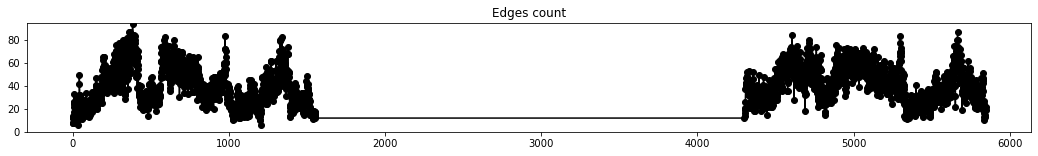

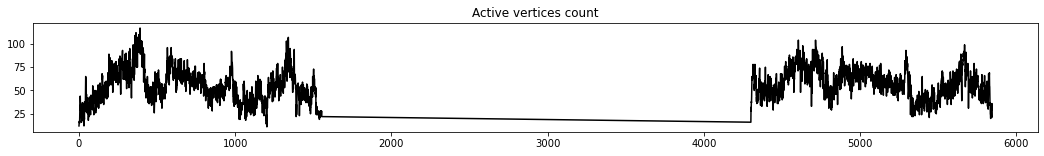

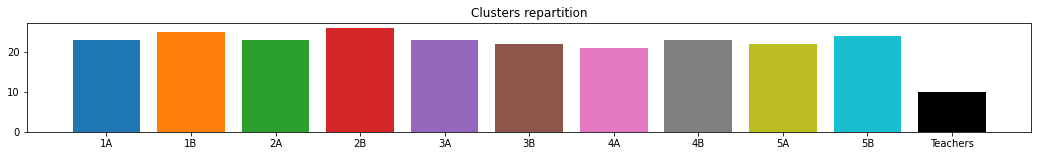

In [2]:
' Open dataset '

# Reinitialize global variables
SaveBarcodes, SaveBarcodesDionysus = dict(), dict()

# Select a temporal graph in the list
Dataset = Files[0]

# Load dataset
start_time = ChronometerStart('Loading dataset '+Dataset+'...\n')
Times, Vertices, Edges_by_times, Edges_unique, Labels_nodes, Labels_color = LoadDataset(Dataset)
ChronometerStop(start_time, 's')

# Plot dataset 
PlotDataset()
plt.show()

When studying a temporal graph, it is common to employ *timeslicing*. The output is a sequence of graphs.
We implemented here two timeslicing methods: *partition* and *sliding-window*. Both depends on a resolution parameter.

As an example, we apply the partition timeslicing with resolution 50, and show some of the resulting graphs.

Create graphs...Execution time: 1 s.


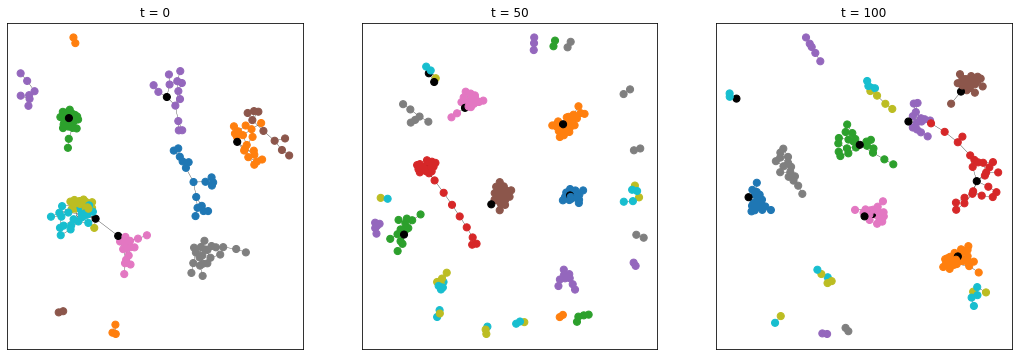

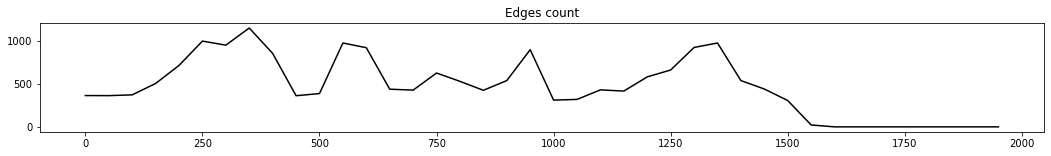

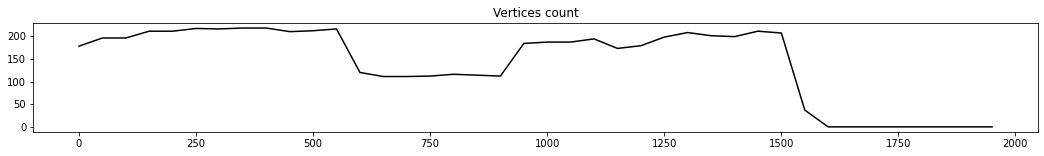

In [3]:
' Timeslicing '

# Parameters
Resolution = 50
ResolutionType = ['partition', 'sliding'][0]
MaximalTime = 2000
Nodes = ['active', 'all'][0]

# Create graphs
start_time = ChronometerStart('Create graphs...')
Graphs = DefineGraphs(Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, TypeNodes=Nodes, verbose=False)
ChronometerStop(start_time, 's')

# Plot a few graphs
PlotGraphs(Tmax=MaximalTime, resolution=Resolution, Tcurrent=0, Graphs=Graphs, TypeResolution=ResolutionType)
    
# Plot curves
PlotCurves(Graphs=Graphs)

We now apply our suggestion resolution method, with the partition timeslicing first.

Barcode 399/399, resolution = 399... Duration 0:03:58/0:00:00. Execution time: 243 s.
The suggested resolutions are: [5, 144, 163, 196, 245]


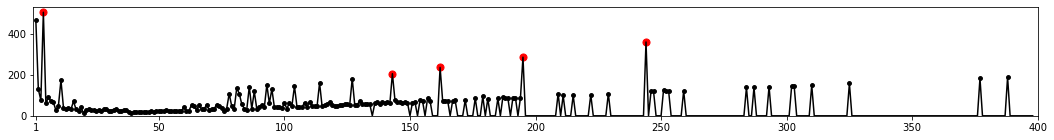

In [4]:
' Resolution suggestion '

# Parameters
ResolutionType = ['partition', 'sliding'][0]

# Compute suggestion curve 
SuggestionTmin, SuggestionTmax = 1, 400
ResolutionsToTest = list(range(SuggestionTmin,SuggestionTmax))
SuggestionCurve = ComputeSuggestionCurve(ResolutionsToTest=ResolutionsToTest, Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, TypeNodes=Nodes, verbose=True, plot=False)

# Select most prominent peaks
N_peaks = 5
TopPeaks = GetTopPeaks(SuggestionCurve,N_peaks)
TopResolutions = [ResolutionsToTest[i]+1 for i in TopPeaks]
print('The suggested resolutions are:', TopResolutions)

# Plot
plt.figure(figsize=(18,2))
plt.plot(ResolutionsToTest[:-1],SuggestionCurve, color='black')
positivevalues = [i for i in range(len(SuggestionCurve)) if SuggestionCurve[i]>0]
plt.scatter([ResolutionsToTest[i] for i in positivevalues],[SuggestionCurve[i] for i in positivevalues], color='black', s=15)
plt.scatter([ResolutionsToTest[i] for i in TopPeaks],[SuggestionCurve[i] for i in TopPeaks], color='red', s=50)
plt.xlim(0,SuggestionTmax-1); plt.ylim(bottom=0); plt.xticks([1]+list(plt.xticks()[0][1:]));

# # Plot smaller
# plt.figure(figsize=(10,2))
# plt.plot(ResolutionsToTest[:-1],SuggestionCurve, color='black')
# positivevalues = [i for i in range(len(SuggestionCurve)) if SuggestionCurve[i]>0]
# plt.scatter([ResolutionsToTest[i] for i in positivevalues],[SuggestionCurve[i] for i in positivevalues], color='black', s=15)
# plt.scatter([ResolutionsToTest[i] for i in TopPeaks],[SuggestionCurve[i] for i in TopPeaks], color='red', s=50)
# plt.xlim(0,SuggestionTmax-1); plt.ylim(bottom=0); plt.xticks([1]+list(plt.xticks()[0][1:]));

# # Plot smaller without top peaks
# plt.figure(figsize=(10,2))
# plt.plot(ResolutionsToTest[:-1],SuggestionCurve, color='black')
# positivevalues = [i for i in range(len(SuggestionCurve)) if SuggestionCurve[i]>0]
# plt.scatter([ResolutionsToTest[i] for i in positivevalues],[SuggestionCurve[i] for i in positivevalues], color='black', s=15)
# plt.xlim(0,SuggestionTmax-1); plt.ylim(bottom=0); plt.xticks([1]+list(plt.xticks()[0][1:]));

The output indicates 5, 144, 163, 196 and 245 as critical resolutions where the temporal graph changes its behavior.

However, as explained in our article, we recommend the user to use the sliding window-timeslicing instead of partition.
We now compute the suggestion curve for the sliding-window method.

Barcode 249/249, resolution = 498... Duration 0:02:50/0:00:00. Execution time: 175 s.
The suggested resolutions are: [8, 18, 76, 154, 282]


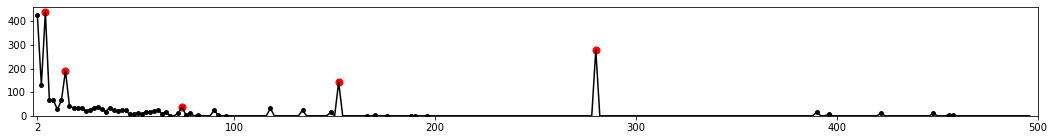

In [5]:
' Resolution suggestion '

# Parameters
ResolutionType = ['partition', 'sliding'][1]

# Compute suggestion curve 
N_peaks = 5
SuggestionTmin, SuggestionTmax = 2, 500 
ResolutionsToTest = list(range(SuggestionTmin,SuggestionTmax,2))
SuggestionCurve = ComputeSuggestionCurve(ResolutionsToTest=ResolutionsToTest, Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, TypeNodes=Nodes, verbose=True, plot=False)

# Select most prominent peaks
TopPeaks = GetTopPeaks(SuggestionCurve,N_peaks)
TopResolutions = [ResolutionsToTest[i]+2 for i in TopPeaks]
print('The suggested resolutions are:', TopResolutions)

# Plot
plt.figure(figsize=(18,2))
plt.plot(ResolutionsToTest[:-1],SuggestionCurve, color='black')
positivevalues = [i for i in range(len(SuggestionCurve)) if SuggestionCurve[i]>0]
plt.scatter([ResolutionsToTest[i] for i in positivevalues],[SuggestionCurve[i] for i in positivevalues], color='black', s=15)
plt.scatter([ResolutionsToTest[i] for i in TopPeaks],[SuggestionCurve[i] for i in TopPeaks], color='red', s=50)
plt.xlim(0,SuggestionTmax-2); plt.ylim(bottom=0); plt.xticks([2]+list(plt.xticks()[0][1:]));

# # Plot smaller
# plt.figure(figsize=(10,2))
# plt.plot(ResolutionsToTest[:-1],SuggestionCurve, color='black')
# positivevalues = [i for i in range(len(SuggestionCurve)) if SuggestionCurve[i]>0]
# plt.scatter([ResolutionsToTest[i] for i in positivevalues],[SuggestionCurve[i] for i in positivevalues], color='black', s=15)
# plt.scatter([ResolutionsToTest[i] for i in TopPeaks],[SuggestionCurve[i] for i in TopPeaks], color='red', s=50)
# plt.xlim(0,SuggestionTmax-2); plt.ylim(bottom=0); plt.xticks([2]+list(plt.xticks()[0][1:]));

The output indicates 8, 18, 76, 154 and 282 as critical resolutions where the temporal graph changes its behavior.

We now wish to understand why these resolutions have been chosen.
Let us consider the resolution 8.
We plot below the colored barcodes for the resolutions 6 and 8, in order to visualize what global change occured.

Get barcode... Event 64460/64460... Duration 0:00:29/0:00:00. 
There are 3688 nonzero bars (and 17176 bars)
Execution time: 30 s.


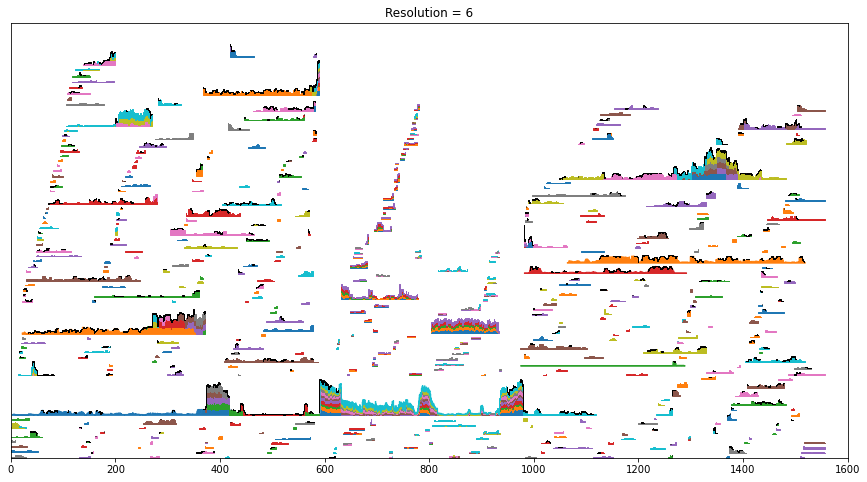

In [6]:
' Colored barcode '

# Compute colored barcode
Resolution = 6
start_time = ChronometerStart('GetZigZag... ')
BARCODE, BARCODE_elements = GetZigZag(Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, TypeNodes=Nodes, verbose=True, sanitycheck=False, plot=False)
ChronometerStop(start_time, 's')

# Plot colored barcode
SmallBarsHeight, SmallBarsLength = 5, 5
GRID, FILL = InitializePlotZigZagBarcode(BARCODE, BARCODE_elements, Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, Vertices=Vertices, small_bars_height=SmallBarsHeight, small_bars_length=SmallBarsLength)
PlotZigZagBarcode(FILL, TypeResolution=ResolutionType, show_grid=False)
plt.title('Resolution = '+repr(Resolution)); plt.yticks([]); 
plt.xlim([0,1600]); plt.ylim(bottom=0);

# Save
b1, e1, r1 = BARCODE, BARCODE_elements, Resolution

Get barcode... Event 56576/56576... Duration 0:00:25/0:00:00. 
There are 2838 nonzero bars (and 13182 bars)
Execution time: 27 s.


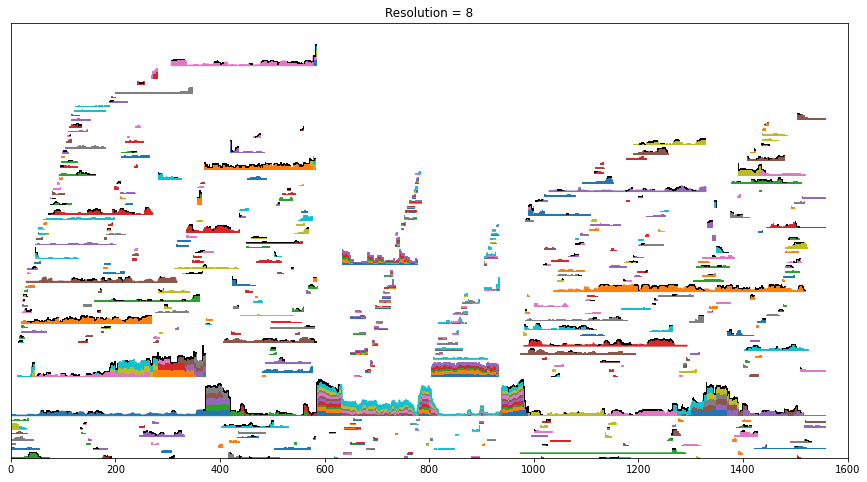

In [7]:
' Colored barcode '

# Compute colored barcode
Resolution = 8
start_time = ChronometerStart('GetZigZag... ')
BARCODE, BARCODE_elements = GetZigZag(Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, TypeNodes=Nodes, verbose=True, sanitycheck=False, plot=False)
ChronometerStop(start_time, 's')

# Plot colored barcode
SmallBarsHeight, SmallBarsLength = 5, 5
GRID, FILL = InitializePlotZigZagBarcode(BARCODE, BARCODE_elements, Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, Vertices=Vertices, small_bars_height=SmallBarsHeight, small_bars_length=SmallBarsLength)
PlotZigZagBarcode(FILL, TypeResolution=ResolutionType, show_grid=False)
plt.title('Resolution = '+repr(Resolution)); plt.yticks([]);
plt.xlim([0,1600]); plt.ylim(bottom=0);

# Save
b2, e2, r2 = BARCODE, BARCODE_elements, Resolution

In order to observe where the barcodes differ, we can use the bottleneck distance.

Bottleneck distance = 439.0 and Wasserstein distance = 439.0015326391259
Maximal costs encountered: [439, 155, 90, 90]


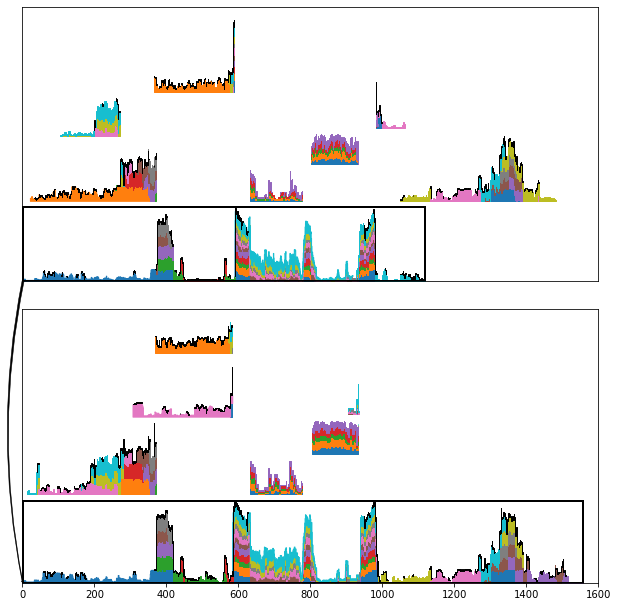

In [8]:
' Explainability with the bottleneck distance '

# Compute optimal matching of bottleneck distance
MaxMatching = WorstPairBottleneck(b1,b2,10)

# Plot
Tmax = MaximalTime
res = ResolutionType
SmallBarsHeight = 50

%matplotlib inline
fig = plt.figure( figsize=(10,10) ); ax1 = fig.add_subplot(211); ax2 = fig.add_subplot(212)

GRID1, FILL1 = InitializePlotZigZagBarcode(b1, e1, Tmax=Tmax, resolution=r1, TypeResolution=res, Vertices=Vertices, small_bars_height=SmallBarsHeight, small_bars_length=SmallBarsLength)
for fill in FILL1: 
    if res == 'partition': ax1.fill_between(fill[0],fill[1],fill[2],color=fill[3])
    if res == 'sliding': ax1.fill_between(fill[0],fill[1],fill[2],color=fill[3], step='pre')

GRID2, FILL2 = InitializePlotZigZagBarcode(b2, e2, Tmax=Tmax, resolution=r2, TypeResolution=res, Vertices=Vertices, small_bars_height=SmallBarsHeight, small_bars_length=SmallBarsLength)
for fill in FILL2: 
    if res == 'partition': ax2.fill_between(fill[0],fill[1],fill[2],color=fill[3])
    if res == 'sliding': ax2.fill_between(fill[0],fill[1],fill[2],color=fill[3], step='pre')
                     
# Plot otimum
plt_arrow = True
ind = MaxMatching[0]
if ind != -1:
    x1=np.where(np.sum(GRID1==ind+1,1)>0)[0][0]
    x2=np.where(np.sum(GRID1==ind+1,1)>0)[0][-1]
    y1=np.where(np.sum(GRID1==ind+1,0)>0)[0][0]
    y2=np.where(np.sum(GRID1==ind+1,0)>0)[0][-1]+1
    patch = patches.Polygon(np.array([[x1,y1],[x2,y1],[x2,y2],[x1,y2]]), lw=2, closed=True, fill=False)
    ax1.add_patch(patch)
    xyA = [x1,y1]
else:
    plt_arrow = False

ind = MaxMatching[1]
if ind != -1:
    x1=np.where(np.sum(GRID2==ind+1,1)>0)[0][0]
    x2=np.where(np.sum(GRID2==ind+1,1)>0)[0][-1]
    y1=np.where(np.sum(GRID2==ind+1,0)>0)[0][0]
    y2=np.where(np.sum(GRID2==ind+1,0)>0)[0][-1]+1
    patch = patches.Polygon(np.array([[x1,y1],[x2,y1],[x2,y2],[x1,y2]]), lw=2, closed=True, fill=False)
    ax2.add_patch(patch)
    xyB = [x1,y1]
else:
    plt_arrow = False
    
if plt_arrow:
    arrow = patches.ConnectionPatch(
        xyA,
        xyB,
        coordsA=ax1.transData,
        coordsB=ax2.transData,
        color="black",
        mutation_scale=5,  # controls arrow head size
        linewidth=0.5,
        arrowstyle = 'Fancy',
        connectionstyle="arc3,rad=.1"
    )
    fig.patches.append(arrow)
    

#ax1.set_title('Resolution = '+repr(r1)); 
#ax2.set_title('Resolution = '+repr(r2)); 
ax1.set_xlim([0,1600]); ax2.set_xlim([0,1600])
ax1.set_ylim(bottom=0); ax2.set_ylim(bottom=0);
ax1.set_xticks([]); ax1.set_yticks([]); ax2.set_yticks([]); 
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.0,hspace=0.1); plt.show()

#fig.savefig('ComparisonResolution_PrimarySchool_6-8.pdf');

As we can see, when going from resolution 6 to 8, a large bar is formed, which lasts throughout the experiment.

Let us repeat the experiment with the resolution 154.
We first represent the colored barcode for the resolutions 152 and 154, and then represent the bottleneck distance.

Get barcode... Event 20714/20714... Duration 0:00:06/0:00:00. 
There are 140 nonzero bars (and 887 bars)
Execution time: 7 s.


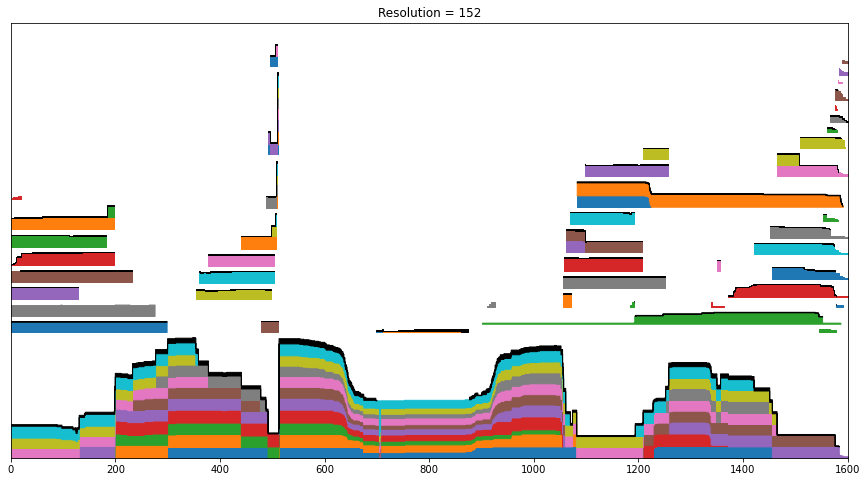

In [9]:
' Colored barcode '

# Compute colored barcode
Resolution = 152
start_time = ChronometerStart('GetZigZag... ')
BARCODE, BARCODE_elements = GetZigZag(Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, TypeNodes=Nodes, verbose=True, sanitycheck=False, plot=False)
ChronometerStop(start_time, 's')

# Plot colored barcode
SmallBarsHeight, SmallBarsLength = 5, 5
GRID, FILL = InitializePlotZigZagBarcode(BARCODE, BARCODE_elements, Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, Vertices=Vertices, small_bars_height=SmallBarsHeight, small_bars_length=SmallBarsLength)
PlotZigZagBarcode(FILL, TypeResolution=ResolutionType, show_grid=False)
plt.title('Resolution = '+repr(Resolution)); plt.yticks([]); 
plt.xlim([0,1600]); plt.ylim(bottom=0);

# Save
b1, e1, r1 = BARCODE, BARCODE_elements, Resolution

Get barcode... Event 20638/20638... Duration 0:00:06/0:00:00. 
There are 138 nonzero bars (and 879 bars)
Execution time: 7 s.


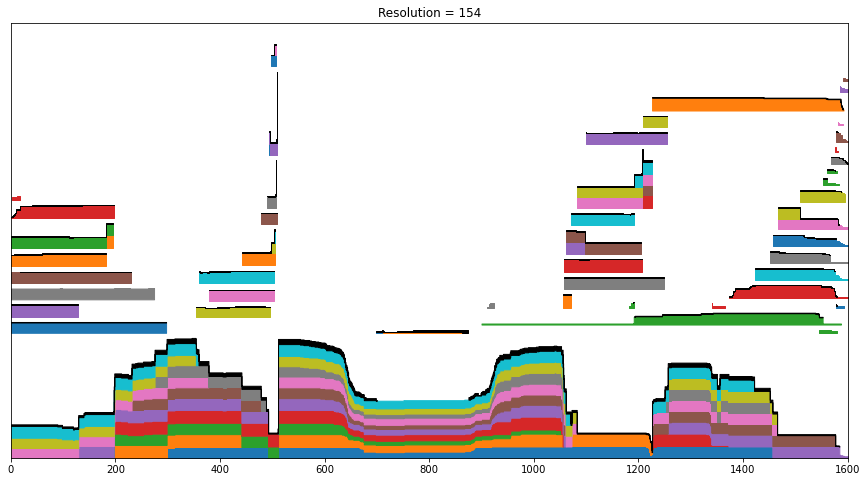

In [10]:
' Colored barcode '

# Compute colored barcode
Resolution = 154
start_time = ChronometerStart('GetZigZag... ')
BARCODE, BARCODE_elements = GetZigZag(Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, TypeNodes=Nodes, verbose=True, sanitycheck=False, plot=False)
ChronometerStop(start_time, 's')

# Plot colored barcode
SmallBarsHeight, SmallBarsLength = 5, 5
GRID, FILL = InitializePlotZigZagBarcode(BARCODE, BARCODE_elements, Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, Vertices=Vertices, small_bars_height=SmallBarsHeight, small_bars_length=SmallBarsLength)
PlotZigZagBarcode(FILL, TypeResolution=ResolutionType, show_grid=False)
plt.title('Resolution = '+repr(Resolution)); plt.yticks([]); 
plt.xlim([0,1600]); plt.ylim(bottom=0);

# Save
b2, e2, r2 = BARCODE, BARCODE_elements, Resolution

Bottleneck distance = 144.0 and Wasserstein distance = 144.003713538273
Maximal costs encountered: [144, 60.5, 52, 50]


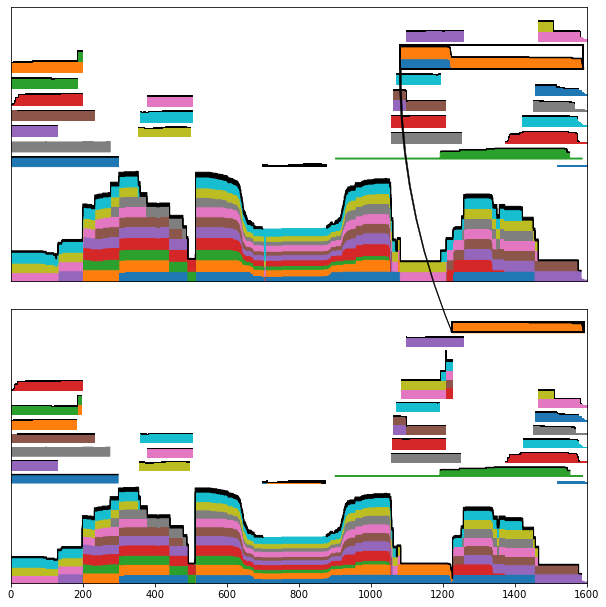

In [11]:
' Explainability with the bottleneck distance '

# Compute optimal matching of bottleneck distance
MaxMatching = WorstPairBottleneck(b1,b2)

# Plot
Tmax = MaximalTime
res = ResolutionType
SmallBarsHeight = 2
SmallBarsLength = 100

%matplotlib inline
fig = plt.figure( figsize=(10,10) ); ax1 = fig.add_subplot(211); ax2 = fig.add_subplot(212)

GRID1, FILL1 = InitializePlotZigZagBarcode(b1, e1, Tmax=Tmax, resolution=r1, TypeResolution=res, Vertices=Vertices, small_bars_height=SmallBarsHeight, small_bars_length=SmallBarsLength)
for fill in FILL1: 
    if res == 'partition': ax1.fill_between(fill[0],fill[1],fill[2],color=fill[3])
    if res == 'sliding': ax1.fill_between(fill[0],fill[1],fill[2],color=fill[3], step='pre')

GRID2, FILL2 = InitializePlotZigZagBarcode(b2, e2, Tmax=Tmax, resolution=r2, TypeResolution=res, Vertices=Vertices, small_bars_height=SmallBarsHeight, small_bars_length=SmallBarsLength)
for fill in FILL2: 
    if res == 'partition': ax2.fill_between(fill[0],fill[1],fill[2],color=fill[3])
    if res == 'sliding': ax2.fill_between(fill[0],fill[1],fill[2],color=fill[3], step='pre')
                     
# Plot otimum
plt_arrow = True
ind = MaxMatching[0]
if ind != -1:
    x1=np.where(np.sum(GRID1==ind+1,1)>0)[0][0]
    x2=np.where(np.sum(GRID1==ind+1,1)>0)[0][-1]
    y1=np.where(np.sum(GRID1==ind+1,0)>0)[0][0]
    y2=np.where(np.sum(GRID1==ind+1,0)>0)[0][-1]+1
    patch = patches.Polygon(np.array([[x1,y1],[x2,y1],[x2,y2],[x1,y2]]), lw=2, closed=True, fill=False)
    ax1.add_patch(patch)
    xyA = [x1,y1]
else:
    plt_arrow = False

ind = MaxMatching[1]
if ind != -1:
    x1=np.where(np.sum(GRID2==ind+1,1)>0)[0][0]
    x2=np.where(np.sum(GRID2==ind+1,1)>0)[0][-1]
    y1=np.where(np.sum(GRID2==ind+1,0)>0)[0][0]
    y2=np.where(np.sum(GRID2==ind+1,0)>0)[0][-1]+1
    patch = patches.Polygon(np.array([[x1,y1],[x2,y1],[x2,y2],[x1,y2]]), lw=2, closed=True, fill=False)
    ax2.add_patch(patch)
    xyB = [x1,y1]
else:
    plt_arrow = False
    
if plt_arrow:
    arrow = patches.ConnectionPatch(
        xyA,
        xyB,
        coordsA=ax1.transData,
        coordsB=ax2.transData,
        color="black",
        mutation_scale=5,  # controls arrow head size
        linewidth=0.5,
        arrowstyle = 'Fancy',
        connectionstyle="arc3,rad=.1"
    )
    fig.patches.append(arrow)
    
#ax1.set_title('Resolution = '+repr(r1)); 
#ax2.set_title('Resolution = '+repr(r2)); 
ax1.set_xlim([0,1600]); ax2.set_xlim([0,1600]);
ax1.set_ylim(bottom=0); ax2.set_ylim(bottom=0);
ax1.set_xticks([]); ax1.set_yticks([]); ax2.set_yticks([]); 
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.0,hspace=0.1); plt.show()

#fig.savefig('ComparisonResolution_PrimarySchool_152-154.pdf');

For the resolution 152, one sees that there exist a few timestamps, around 1200, where no blue nodes are present in the graphs.
However, for resolution 154, a blue component exists all along the experiment, modifying the global structure of the barcode.

As a last illustration, we compare the colored barcodes in the case of partition timeslicing, for resolution 154.

Get barcode... Event 22416/22416... Duration 0:00:08/0:00:00. 
There are 89 nonzero bars (and 1003 bars)
Execution time: 9 s.


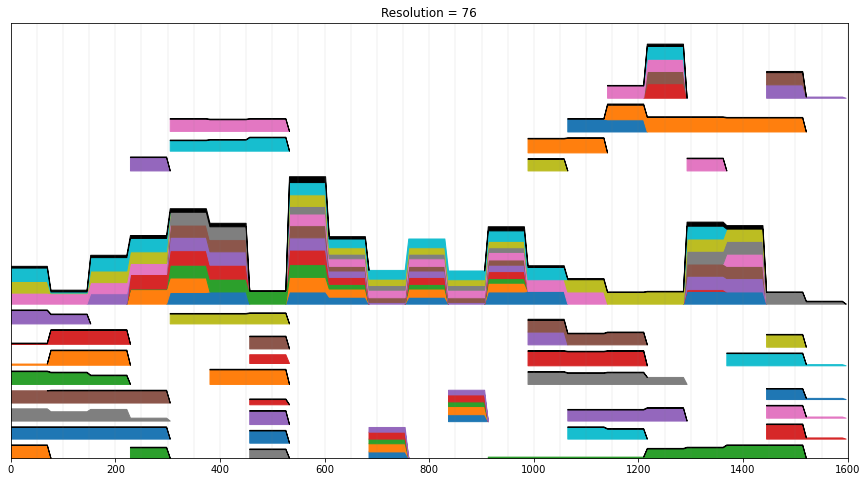

In [12]:
' Colored barcode '

# Compute colored barcode
Resolution = 76
ResolutionType = ['partition', 'sliding'][0]
start_time = ChronometerStart('GetZigZag... ')
BARCODE, BARCODE_elements = GetZigZag(Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, TypeNodes=Nodes, verbose=True, sanitycheck=False, plot=False)
ChronometerStop(start_time, 's')

# Plot colored barcode
SmallBarsHeight, SmallBarsLength = 10, 10
GRID, FILL = InitializePlotZigZagBarcode(BARCODE, BARCODE_elements, Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, Vertices=Vertices, small_bars_height=SmallBarsHeight, small_bars_length=SmallBarsLength)
PlotZigZagBarcode(FILL, TypeResolution=ResolutionType, show_grid=True)
plt.title('Resolution = '+repr(Resolution)); plt.yticks([]); 
plt.xlim([0,1600]); plt.ylim(bottom=0);

# Save
b2, e2, r2 = BARCODE, BARCODE_elements, Resolution

Get barcode... Event 24954/24954... Duration 0:00:07/0:00:00. 
There are 242 nonzero bars (and 1316 bars)
Execution time: 8 s.


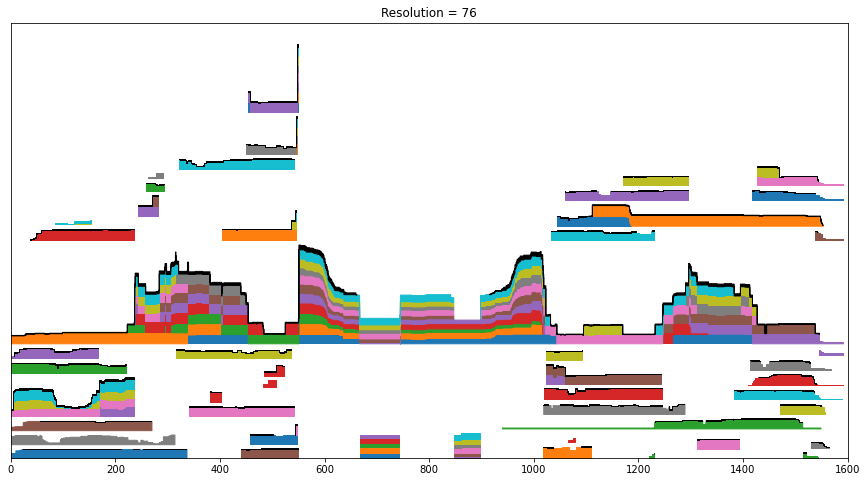

In [13]:
' Colored barcode '

# Compute colored barcode
Resolution = 76
ResolutionType = ['partition', 'sliding'][1]
start_time = ChronometerStart('GetZigZag... ')
BARCODE, BARCODE_elements = GetZigZag(Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, TypeNodes=Nodes, verbose=True, sanitycheck=False, plot=False)
ChronometerStop(start_time, 's')

# Plot colored barcode
SmallBarsHeight, SmallBarsLength = 10, 10
GRID, FILL = InitializePlotZigZagBarcode(BARCODE, BARCODE_elements, Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, Vertices=Vertices, small_bars_height=SmallBarsHeight, small_bars_length=SmallBarsLength)
PlotZigZagBarcode(FILL, TypeResolution=ResolutionType, show_grid=False)
plt.title('Resolution = '+repr(Resolution)); plt.yticks([]); 
plt.xlim([0,1600]); plt.ylim(bottom=0);

# Save
b2, e2, r2 = BARCODE, BARCODE_elements, Resolution

In the sliding window layout, there are some different connected components over time when compared with partition, since the connected component can merge, split, or even disappear between a timeslice and a consecutive one.

# II - High School Network

Loading dataset HighSchool...
Maximal time value = 18178
Number of timestamps: 7375
Number of vertices: 327
Number of edges events: 188508
Number of edges: 5818
Number of labels: 9
Execution time: 53 s.


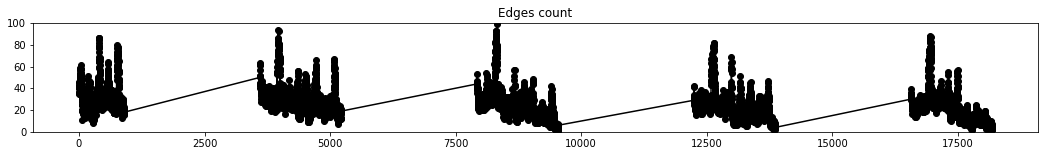

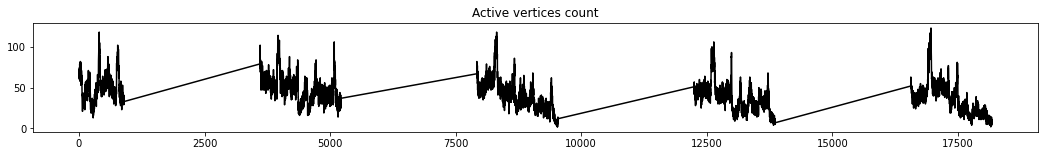

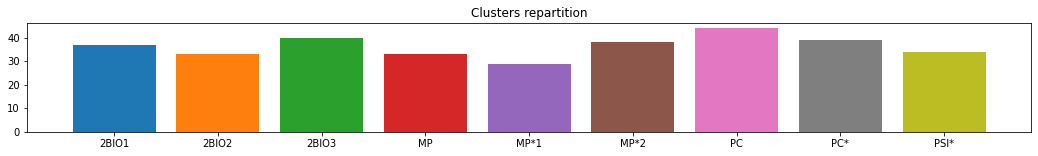

In [14]:
' Open dataset '

# Reinitialize global variables 
SaveBarcodes, SaveBarcodesDionysus = dict(), dict()

# Select a temporal graph in the list
Dataset = Files[1]

# Load dataset
start_time = ChronometerStart('Loading dataset '+Dataset+'...\n')
Times, Vertices, Edges_by_times, Edges_unique, Labels_nodes, Labels_color = LoadDataset(Dataset)
ChronometerStop(start_time, 's')

# Plot dataset 
PlotDataset()
plt.show()

Barcode 249/249, resolution = 498... Duration 0:00:52/0:00:00. Execution time: 55 s.
The suggested resolutions are: [8, 12, 46, 92, 104]


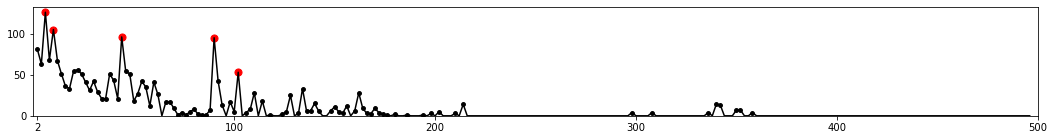

In [15]:
' Resolution suggestion '

# Parameters
Resolution = 100
ResolutionType = ['partition', 'sliding'][1]
MaximalTime = 2000
Nodes = ['active', 'all'][0]

# Compute suggestion curve 
N_peaks = 5
SuggestionTmin, SuggestionTmax = 2, 500 
ResolutionsToTest = list(range(SuggestionTmin,SuggestionTmax,2))
SuggestionCurve = ComputeSuggestionCurve(ResolutionsToTest=ResolutionsToTest, Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, TypeNodes=Nodes, verbose=True, plot=False)

# Select most prominent peaks
TopPeaks = GetTopPeaks(SuggestionCurve,N_peaks)
TopResolutions = [ResolutionsToTest[i]+2 for i in TopPeaks]
print('The suggested resolutions are:', TopResolutions)

# Plot
plt.figure(figsize=(18,2))
plt.plot(ResolutionsToTest[:-1],SuggestionCurve, color='black')
positivevalues = [i for i in range(len(SuggestionCurve)) if SuggestionCurve[i]>0]
plt.scatter([ResolutionsToTest[i] for i in positivevalues],[SuggestionCurve[i] for i in positivevalues], color='black', s=15)
plt.scatter([ResolutionsToTest[i] for i in TopPeaks],[SuggestionCurve[i] for i in TopPeaks], color='red', s=50)
plt.xlim(0,SuggestionTmax-2); plt.ylim(bottom=0); plt.xticks([2]+list(plt.xticks()[0][1:]));

# # Plot smaller
# plt.figure(figsize=(10,2))
# plt.plot(ResolutionsToTest[:-1],SuggestionCurve, color='black')
# positivevalues = [i for i in range(len(SuggestionCurve)) if SuggestionCurve[i]>0]
# plt.scatter([ResolutionsToTest[i] for i in positivevalues],[SuggestionCurve[i] for i in positivevalues], color='black', s=15)
# plt.scatter([ResolutionsToTest[i] for i in TopPeaks],[SuggestionCurve[i] for i in TopPeaks], color='red', s=50)
# plt.xlim(0,SuggestionTmax-2); plt.ylim(bottom=0); plt.xticks([2]+list(plt.xticks()[0][1:]));

Get barcode... Event 8158/8158... Duration 0:00:04/0:00:00. 
There are 343 nonzero bars (and 1784 bars)
Execution time: 4 s.


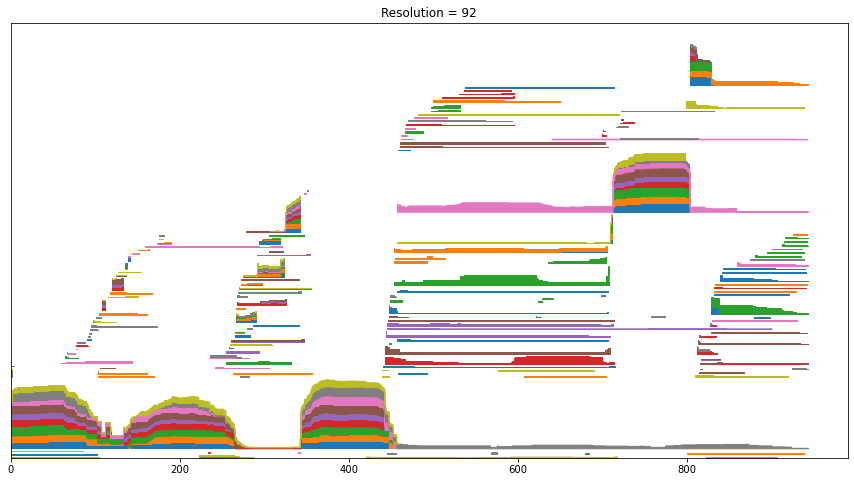

In [16]:
' Colored barcode '

# Compute colored barcode
Resolution = 92
start_time = ChronometerStart('GetZigZag... ')
BARCODE, BARCODE_elements = GetZigZag(Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, TypeNodes=Nodes, verbose=True, sanitycheck=False, plot=False)
ChronometerStop(start_time, 's')

# Plot colored barcode
SmallBarsHeight, SmallBarsLength = 3, 3
GRID, FILL = InitializePlotZigZagBarcode(BARCODE, BARCODE_elements, Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, Vertices=Vertices, small_bars_height=SmallBarsHeight, small_bars_length=SmallBarsLength)
PlotZigZagBarcode(FILL, TypeResolution=ResolutionType, show_grid=False)
plt.title('Resolution = '+repr(Resolution)); plt.yticks([]); plt.xlim(left=0); plt.ylim(bottom=0);

# III - Hospital

Loading dataset Hospital...
Maximal time value = 17382
Number of timestamps: 9453
Number of vertices: 75
Number of edges events: 32424
Number of edges: 1139
Number of labels: 4
Execution time: 9 s.


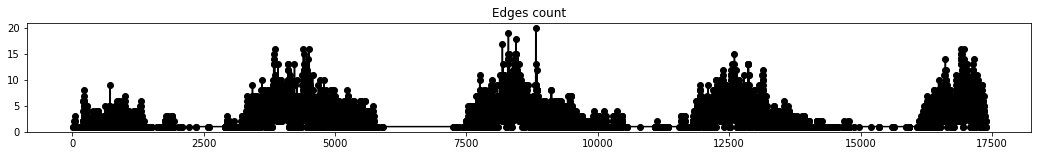

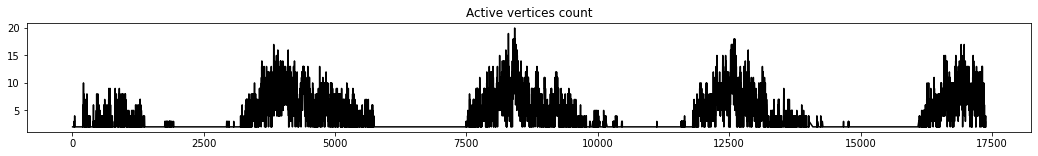

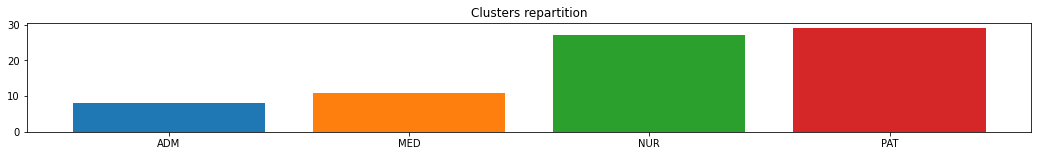

In [17]:
' Open dataset '

# Reinitialize global variables
SaveBarcodes, SaveBarcodesDionysus = dict(), dict()

# Select a temporal graph in the list
Dataset = Files[2]

# Load dataset
start_time = ChronometerStart('Loading dataset '+Dataset+'...\n')
Times, Vertices, Edges_by_times, Edges_unique, Labels_nodes, Labels_color = LoadDataset(Dataset)
ChronometerStop(start_time, 's')

# Plot dataset 
PlotDataset()
plt.show()

Barcode 249/249, resolution = 498... Duration 0:00:03/0:00:00. Execution time: 4 s.
The suggested resolutions are: [14, 26, 32, 74, 352]


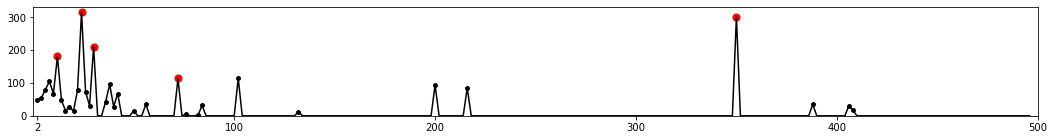

In [18]:
' Resolution suggestion '

# Parameters
Resolution = 100
ResolutionType = ['partition', 'sliding'][1]
MaximalTime = 2000
Nodes = ['active', 'all'][0]

# Compute suggestion curve 
N_peaks = 5
SuggestionTmin, SuggestionTmax = 2, 500 
ResolutionsToTest = list(range(SuggestionTmin,SuggestionTmax,2))
SuggestionCurve = ComputeSuggestionCurve(ResolutionsToTest=ResolutionsToTest, Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, TypeNodes=Nodes, verbose=True, plot=False)

# Select most prominent peaks
TopPeaks = GetTopPeaks(SuggestionCurve,N_peaks)
TopResolutions = [ResolutionsToTest[i]+2 for i in TopPeaks]
print('The suggested resolutions are:', TopResolutions)

# Plot
plt.figure(figsize=(18,2))
plt.plot(ResolutionsToTest[:-1],SuggestionCurve, color='black')
positivevalues = [i for i in range(len(SuggestionCurve)) if SuggestionCurve[i]>0]
plt.scatter([ResolutionsToTest[i] for i in positivevalues],[SuggestionCurve[i] for i in positivevalues], color='black', s=15)
plt.scatter([ResolutionsToTest[i] for i in TopPeaks],[SuggestionCurve[i] for i in TopPeaks], color='red', s=50)
plt.xlim(0,SuggestionTmax-2); plt.ylim(bottom=0); plt.xticks([2]+list(plt.xticks()[0][1:]));

# # Plot smaller
# plt.figure(figsize=(10,2))
# plt.plot(ResolutionsToTest[:-1],SuggestionCurve, color='black')
# positivevalues = [i for i in range(len(SuggestionCurve)) if SuggestionCurve[i]>0]
# plt.scatter([ResolutionsToTest[i] for i in positivevalues],[SuggestionCurve[i] for i in positivevalues], color='black', s=15)
# plt.scatter([ResolutionsToTest[i] for i in TopPeaks],[SuggestionCurve[i] for i in TopPeaks], color='red', s=50)
# plt.xlim(0,SuggestionTmax-2); plt.ylim(bottom=0); plt.xticks([2]+list(plt.xticks()[0][1:]));

Get barcode... Event 1502/1502... Duration 0:00:00/0:00:00. 
There are 107 nonzero bars (and 622 bars)
Execution time: 0 s.


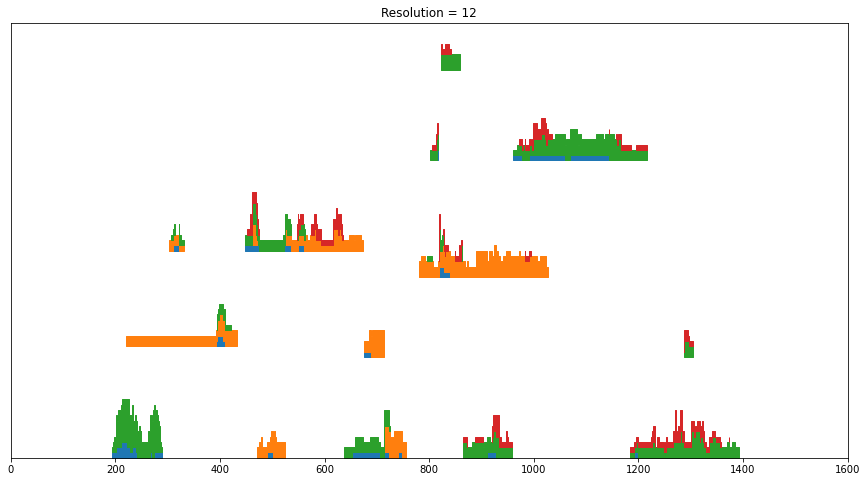

In [19]:
' Colored barcode '

# Compute colored barcode
Resolution = 12
start_time = ChronometerStart('GetZigZag... ')
BARCODE, BARCODE_elements = GetZigZag(Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, TypeNodes=Nodes, verbose=True, sanitycheck=False, plot=False)
ChronometerStop(start_time, 's')

# Plot colored barcode
SmallBarsHeight, SmallBarsLength = 5, 5
GRID, FILL = InitializePlotZigZagBarcode(BARCODE, BARCODE_elements, Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, Vertices=Vertices, small_bars_height=SmallBarsHeight, small_bars_length=SmallBarsLength)
PlotZigZagBarcode(FILL, TypeResolution=ResolutionType, show_grid=False)
plt.title('Resolution = '+repr(Resolution)); plt.yticks([]); 
plt.xlim([0,1600]); plt.ylim(bottom=0);

# Save
b1, e1, r1 = BARCODE, BARCODE_elements, Resolution

Get barcode... Event 1378/1378... Duration 0:00:00/0:00:00. 
There are 94 nonzero bars (and 556 bars)
Execution time: 0 s.


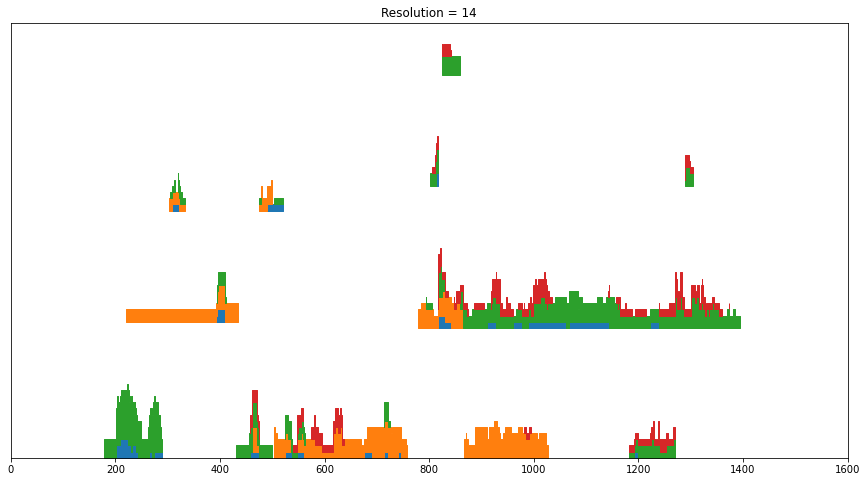

In [20]:
' Colored barcode '

# Compute colored barcode
Resolution = 14
start_time = ChronometerStart('GetZigZag... ')
BARCODE, BARCODE_elements = GetZigZag(Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, TypeNodes=Nodes, verbose=True, sanitycheck=False, plot=False)
ChronometerStop(start_time, 's')

# Plot colored barcode
SmallBarsHeight, SmallBarsLength = 5, 5
GRID, FILL = InitializePlotZigZagBarcode(BARCODE, BARCODE_elements, Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, Vertices=Vertices, small_bars_height=SmallBarsHeight, small_bars_length=SmallBarsLength)
PlotZigZagBarcode(FILL, TypeResolution=ResolutionType, show_grid=False)
plt.title('Resolution = '+repr(Resolution)); plt.yticks([]); 
plt.xlim([0,1600]); plt.ylim(bottom=0);

# Save
b2, e2, r2 = BARCODE, BARCODE_elements, Resolution

Bottleneck distance = 182.0 and Wasserstein distance = 182.0793937796811
Maximal costs encountered: [182, 103, 86, 84]


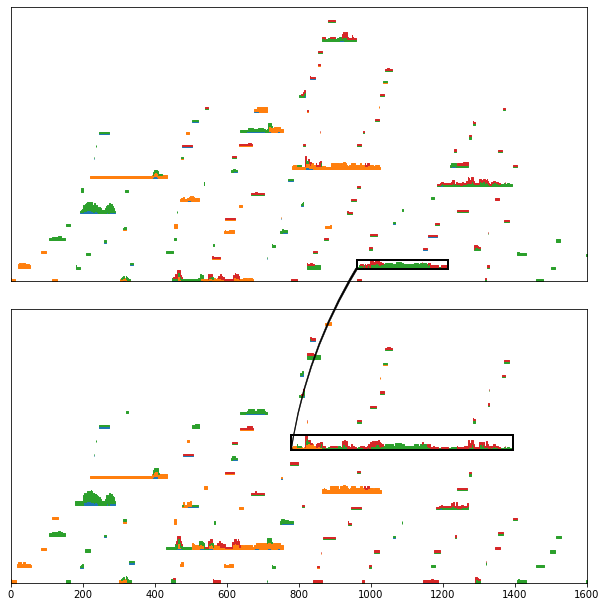

In [21]:
' Explainability with the bottleneck distance '

# Compute optimal matching of bottleneck distance
MaxMatching = WorstPairBottleneck(b1,b2)

# Plot
Tmax = MaximalTime
res = ResolutionType
SmallBarsHeight = 0
SmallBarsLength = 0

%matplotlib inline
fig = plt.figure( figsize=(10,10) ); ax1 = fig.add_subplot(211); ax2 = fig.add_subplot(212)

GRID1, FILL1 = InitializePlotZigZagBarcode(b1, e1, Tmax=Tmax, resolution=r1, TypeResolution=res, Vertices=Vertices, small_bars_height=SmallBarsHeight, small_bars_length=SmallBarsLength)
for fill in FILL1: 
    if res == 'partition': ax1.fill_between(fill[0],fill[1],fill[2],color=fill[3])
    if res == 'sliding': ax1.fill_between(fill[0],fill[1],fill[2],color=fill[3], step='pre')

GRID2, FILL2 = InitializePlotZigZagBarcode(b2, e2, Tmax=Tmax, resolution=r2, TypeResolution=res, Vertices=Vertices, small_bars_height=SmallBarsHeight, small_bars_length=SmallBarsLength)
for fill in FILL2: 
    if res == 'partition': ax2.fill_between(fill[0],fill[1],fill[2],color=fill[3])
    if res == 'sliding': ax2.fill_between(fill[0],fill[1],fill[2],color=fill[3], step='pre')
                     
# Plot otimum
plt_arrow = True
ind = MaxMatching[0]
if ind != -1:
    x1=np.where(np.sum(GRID1==ind+1,1)>0)[0][0]
    x2=np.where(np.sum(GRID1==ind+1,1)>0)[0][-1]
    y1=np.where(np.sum(GRID1==ind+1,0)>0)[0][0]
    y2=np.where(np.sum(GRID1==ind+1,0)>0)[0][-1]+1
    patch = patches.Polygon(np.array([[x1,y1],[x2,y1],[x2,y2],[x1,y2]]), lw=2, closed=True, fill=False)
    ax1.add_patch(patch)
    xyA = [x1,y1]
else:
    plt_arrow = False

ind = MaxMatching[1]
if ind != -1:
    x1=np.where(np.sum(GRID2==ind+1,1)>0)[0][0]
    x2=np.where(np.sum(GRID2==ind+1,1)>0)[0][-1]
    y1=np.where(np.sum(GRID2==ind+1,0)>0)[0][0]
    y2=np.where(np.sum(GRID2==ind+1,0)>0)[0][-1]+1
    patch = patches.Polygon(np.array([[x1,y1],[x2,y1],[x2,y2],[x1,y2]]), lw=2, closed=True, fill=False)
    ax2.add_patch(patch)
    xyB = [x1,y1]
else:
    plt_arrow = False
    
if plt_arrow:
    arrow = patches.ConnectionPatch(
        xyA,
        xyB,
        coordsA=ax1.transData,
        coordsB=ax2.transData,
        color="black",
        mutation_scale=5,  # controls arrow head size
        linewidth=0.5,
        arrowstyle = 'Fancy',
        connectionstyle="arc3,rad=.1"
    )
    fig.patches.append(arrow)
    
#ax1.set_title('Resolution = '+repr(r1)); 
#ax2.set_title('Resolution = '+repr(r2)); 
ax1.set_xlim([0,1600]); ax2.set_xlim([0,1600]);
ax1.set_ylim(bottom=0); ax2.set_ylim(bottom=0);
ax1.set_xticks([]); ax1.set_yticks([]); ax2.set_yticks([]); 
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.0,hspace=0.1); plt.show()

#fig.savefig('ComparisonResolution_Hospital_12-14.pdf');
#fig.savefig('ComparisonResolution_Hospital_12-14_filter5-5.pdf');
#fig.savefig('ComparisonResolution_Hospital_12-14_filter3-3.pdf');

# IV - InVS

Loading dataset InVS...
Maximal time value = 49381
Number of timestamps: 7104
Number of vertices: 92
Number of edges events: 9827
Number of edges: 755
Number of labels: 5
Execution time: 3 s.


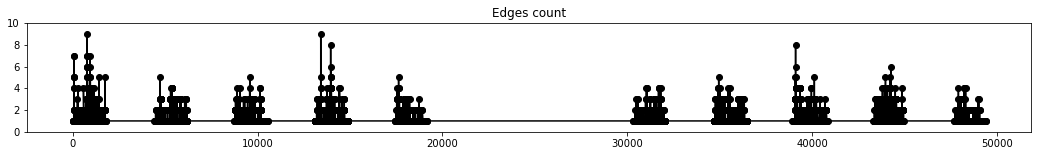

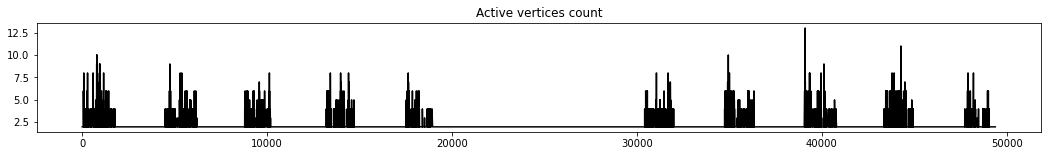

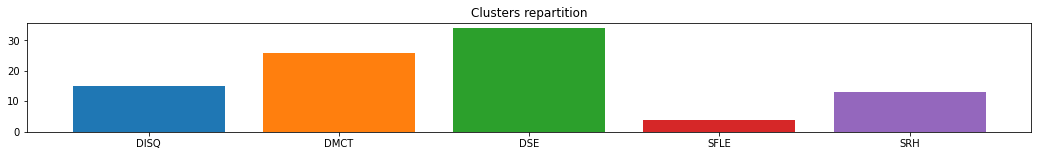

In [22]:
' Open dataset '

# Reinitialize global variables
SaveBarcodes, SaveBarcodesDionysus = dict(), dict()

# Select a temporal graph in the list
Dataset = Files[3]

# Load dataset
start_time = ChronometerStart('Loading dataset '+Dataset+'...\n')
Times, Vertices, Edges_by_times, Edges_unique, Labels_nodes, Labels_color = LoadDataset(Dataset)
ChronometerStop(start_time, 's')

# Plot dataset 
PlotDataset()
plt.show()

Barcode 249/249, resolution = 498... Duration 0:00:03/0:00:00. Execution time: 4 s.
The suggested resolutions are: [66, 148, 158, 164, 202]


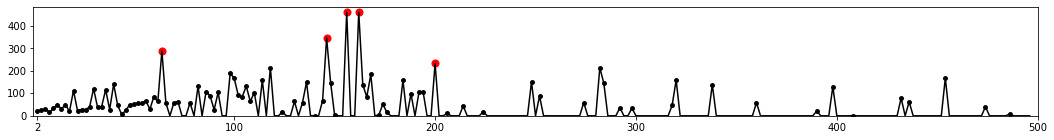

In [23]:
' Resolution suggestion '

# Parameters
Resolution = 100
ResolutionType = ['partition', 'sliding'][1]
MaximalTime = 2000
Nodes = ['active', 'all'][0]

# Compute suggestion curve 
N_peaks = 5
SuggestionTmin, SuggestionTmax = 2, 500 
ResolutionsToTest = list(range(SuggestionTmin,SuggestionTmax,2))
SuggestionCurve = ComputeSuggestionCurve(ResolutionsToTest=ResolutionsToTest, Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, TypeNodes=Nodes, verbose=True, plot=False)

# Select most prominent peaks
TopPeaks = GetTopPeaks(SuggestionCurve,N_peaks)
TopResolutions = [ResolutionsToTest[i]+2 for i in TopPeaks]
print('The suggested resolutions are:', TopResolutions)

# Plot
plt.figure(figsize=(18,2))
plt.plot(ResolutionsToTest[:-1],SuggestionCurve, color='black')
positivevalues = [i for i in range(len(SuggestionCurve)) if SuggestionCurve[i]>0]
plt.scatter([ResolutionsToTest[i] for i in positivevalues],[SuggestionCurve[i] for i in positivevalues], color='black', s=15)
plt.scatter([ResolutionsToTest[i] for i in TopPeaks],[SuggestionCurve[i] for i in TopPeaks], color='red', s=50)
plt.xlim(0,SuggestionTmax-2); plt.ylim(bottom=0); plt.xticks([2]+list(plt.xticks()[0][1:]));

# # Plot smaller
# plt.figure(figsize=(10,2))
# plt.plot(ResolutionsToTest[:-1],SuggestionCurve, color='black')
# positivevalues = [i for i in range(len(SuggestionCurve)) if SuggestionCurve[i]>0]
# plt.scatter([ResolutionsToTest[i] for i in positivevalues],[SuggestionCurve[i] for i in positivevalues], color='black', s=15)
# plt.scatter([ResolutionsToTest[i] for i in TopPeaks],[SuggestionCurve[i] for i in TopPeaks], color='red', s=50)
# plt.xlim(0,SuggestionTmax-2); plt.ylim(bottom=0); plt.xticks([2]+list(plt.xticks()[0][1:]));

Get barcode... Event 1068/1068... Duration 0:00:00/0:00:00. 
There are 107 nonzero bars (and 490 bars)
Execution time: 0 s.


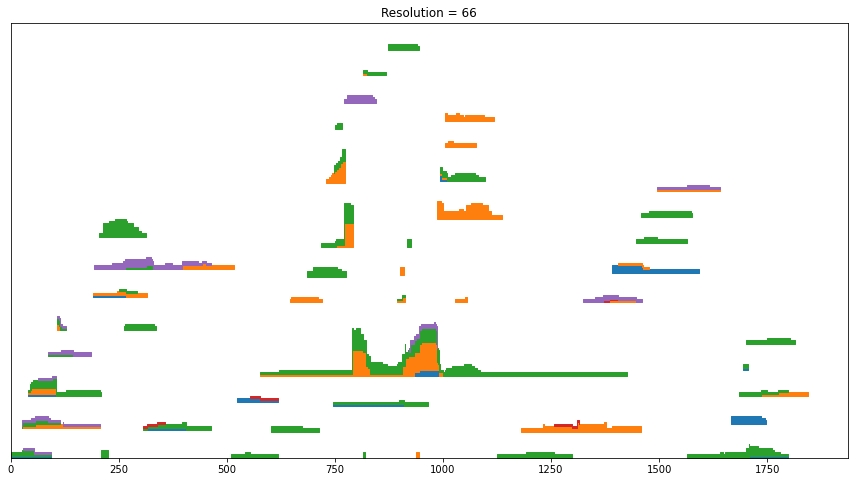

In [24]:
' Colored barcode '

# Compute colored barcode
Resolution = 66
start_time = ChronometerStart('GetZigZag... ')
BARCODE, BARCODE_elements = GetZigZag(Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, TypeNodes=Nodes, verbose=True, sanitycheck=False, plot=False)
ChronometerStop(start_time, 's')

# Plot colored barcode
SmallBarsHeight, SmallBarsLength = 3, 3
GRID, FILL = InitializePlotZigZagBarcode(BARCODE, BARCODE_elements, Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, Vertices=Vertices, small_bars_height=SmallBarsHeight, small_bars_length=SmallBarsLength)
PlotZigZagBarcode(FILL, TypeResolution=ResolutionType, show_grid=False)
plt.title('Resolution = '+repr(Resolution)); plt.yticks([]); plt.xlim(left=0); plt.ylim(bottom=0);

# V - Museum

Loading dataset Museum...
Maximal time value = 1311
Number of timestamps: 1022
Number of vertices: 72
Number of edges events: 6980
Number of edges: 691
Number of labels: 1
Execution time: 2 s.


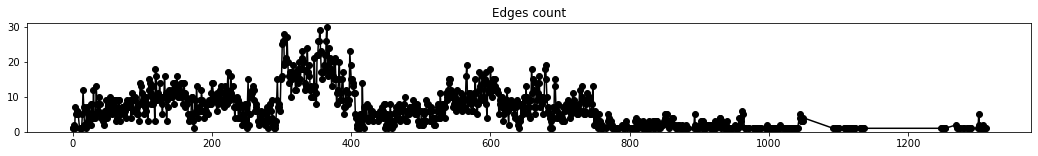

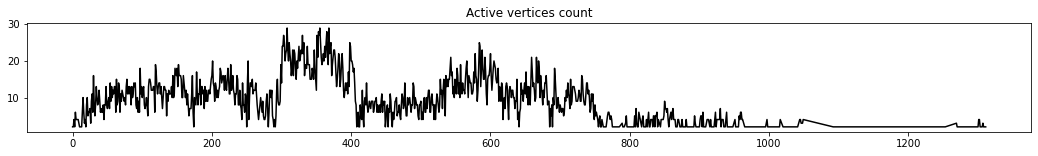

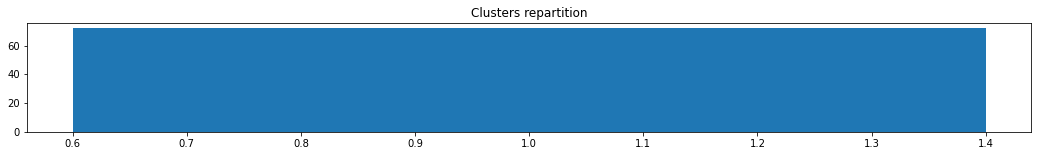

In [25]:
' Open dataset '

# Reinitialize global variables
SaveBarcodes, SaveBarcodesDionysus = dict(), dict()

# Select a temporal graph in the list
Dataset = Files[4]

# Load dataset
start_time = ChronometerStart('Loading dataset '+Dataset+'...\n')
Times, Vertices, Edges_by_times, Edges_unique, Labels_nodes, Labels_color = LoadDataset(Dataset)
ChronometerStop(start_time, 's')

# Plot dataset 
PlotDataset()
plt.show()

Barcode 162/162, resolution = 324... Duration 0:00:07/0:00:00. Execution time: 7 s.
The suggested resolutions are: [6, 12, 36, 52, 320]


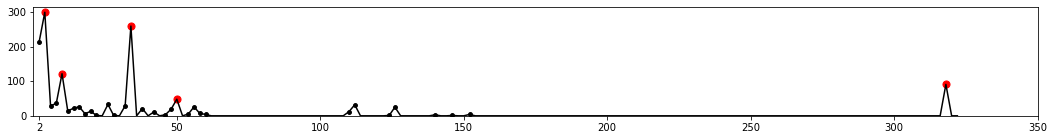

In [26]:
' Resolution suggestion '

# Parameters
Resolution = 100
ResolutionType = ['partition', 'sliding'][1]
MaximalTime = 1300
Nodes = ['active', 'all'][0]

# Compute suggestion curve 
N_peaks = 5
SuggestionTmin, SuggestionTmax = 2, 325 
ResolutionsToTest = list(range(SuggestionTmin,SuggestionTmax,2))
SuggestionCurve = ComputeSuggestionCurve(ResolutionsToTest=ResolutionsToTest, Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, TypeNodes=Nodes, verbose=True, plot=False)

# Select most prominent peaks
TopPeaks = GetTopPeaks(SuggestionCurve,N_peaks)
TopResolutions = [ResolutionsToTest[i]+2 for i in TopPeaks]
print('The suggested resolutions are:', TopResolutions)

# Plot
plt.figure(figsize=(18,2))
plt.plot(ResolutionsToTest[:-1],SuggestionCurve, color='black')
positivevalues = [i for i in range(len(SuggestionCurve)) if SuggestionCurve[i]>0]
plt.scatter([ResolutionsToTest[i] for i in positivevalues],[SuggestionCurve[i] for i in positivevalues], color='black', s=15)
plt.scatter([ResolutionsToTest[i] for i in TopPeaks],[SuggestionCurve[i] for i in TopPeaks], color='red', s=50)
plt.xlim(0,SuggestionTmax-2); plt.ylim(bottom=0); plt.xticks([2]+list(plt.xticks()[0][1:]));

# # Plot smaller
# plt.figure(figsize=(10,2))
# plt.plot(ResolutionsToTest[:-1],SuggestionCurve, color='black')
# positivevalues = [i for i in range(len(SuggestionCurve)) if SuggestionCurve[i]>0]
# plt.scatter([ResolutionsToTest[i] for i in positivevalues],[SuggestionCurve[i] for i in positivevalues], color='black', s=15)
# plt.scatter([ResolutionsToTest[i] for i in TopPeaks],[SuggestionCurve[i] for i in TopPeaks], color='red', s=50)
# plt.xlim(0,SuggestionTmax-2); plt.ylim(bottom=0); plt.xticks([2]+list(plt.xticks()[0][1:]));

Get barcode... Event 2322/2322... Duration 0:00:00/0:00:00. 
There are 102 nonzero bars (and 371 bars)
Execution time: 0 s.


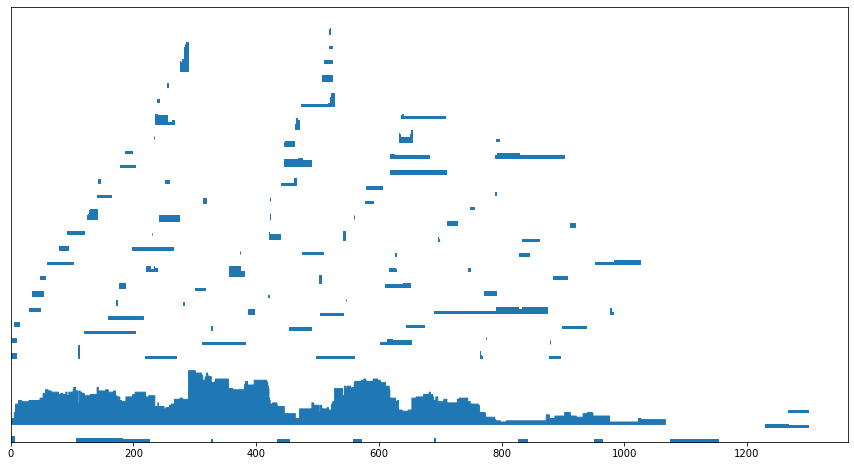

In [27]:
' Colored barcode '

# Compute colored barcode
Resolution = 36
start_time = ChronometerStart('GetZigZag... ')
BARCODE, BARCODE_elements = GetZigZag(Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, TypeNodes=Nodes, verbose=True, sanitycheck=False, plot=False)
ChronometerStop(start_time, 's')

# Plot colored barcode
SmallBarsHeight, SmallBarsLength = 0, 0
GRID, FILL = InitializePlotZigZagBarcode(BARCODE, BARCODE_elements, Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, Vertices=Vertices, small_bars_height=SmallBarsHeight, small_bars_length=SmallBarsLength)
PlotZigZagBarcode(FILL, TypeResolution=ResolutionType, show_grid=False)
plt.yticks([]); plt.xlim(left=0); plt.ylim(bottom=0);
#plt.title('Resolution = '+repr(Resolution)); 

# VI - Enron

Loading dataset Enron...
Maximal time value = 1345
Number of timestamps: 953
Number of vertices: 148
Number of edges events: 24667
Number of edges: 1922
Number of labels: 1
Execution time: 6 s.


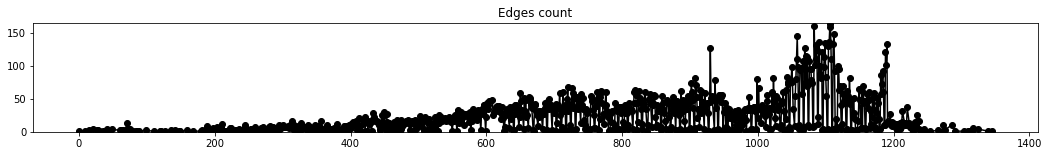

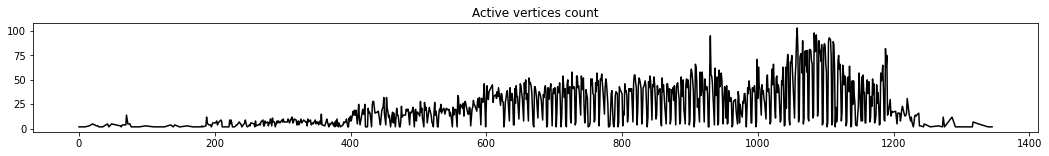

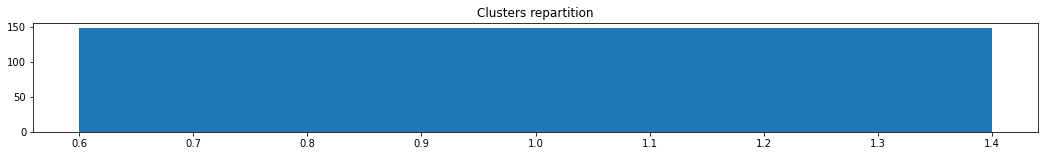

In [28]:
' Open dataset '

# Reinitialize global variables
SaveBarcodes, SaveBarcodesDionysus = dict(), dict()

# Select a temporal graph in the list
Dataset = Files[5]

# Load dataset
start_time = ChronometerStart('Loading dataset '+Dataset+'...\n')
Times, Vertices, Edges_by_times, Edges_unique, Labels_nodes, Labels_color = LoadDataset(Dataset)
ChronometerStop(start_time, 's')

# Plot dataset 
PlotDataset()
plt.show()

Barcode 374/374, resolution = 748... Duration 0:00:53/0:00:00. Execution time: 53 s.
The suggested resolutions are: [6, 12, 24, 36, 68]


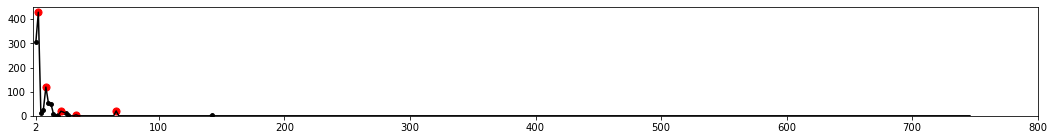

In [29]:
' Resolution suggestion '

# Parameters
Resolution = 100
ResolutionType = ['partition', 'sliding'][1]
MaximalTime = 1400
Nodes = ['active', 'all'][0]

# Compute suggestion curve 
N_peaks = 5
SuggestionTmin, SuggestionTmax = 2, 750 
ResolutionsToTest = list(range(SuggestionTmin,SuggestionTmax,2))
SuggestionCurve = ComputeSuggestionCurve(ResolutionsToTest=ResolutionsToTest, Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, TypeNodes=Nodes, verbose=True, plot=False)

# Select most prominent peaks
TopPeaks = GetTopPeaks(SuggestionCurve,N_peaks)
TopResolutions = [ResolutionsToTest[i]+2 for i in TopPeaks]
print('The suggested resolutions are:', TopResolutions)

# Plot
plt.figure(figsize=(18,2))
plt.plot(ResolutionsToTest[:-1],SuggestionCurve, color='black')
positivevalues = [i for i in range(len(SuggestionCurve)) if SuggestionCurve[i]>0]
plt.scatter([ResolutionsToTest[i] for i in positivevalues],[SuggestionCurve[i] for i in positivevalues], color='black', s=15)
plt.scatter([ResolutionsToTest[i] for i in TopPeaks],[SuggestionCurve[i] for i in TopPeaks], color='red', s=50)
plt.xlim(0,SuggestionTmax-2); plt.ylim(bottom=0); plt.xticks([2]+list(plt.xticks()[0][1:]));

# # Plot smaller
# plt.figure(figsize=(10,2))
# plt.plot(ResolutionsToTest[:-1],SuggestionCurve, color='black')
# positivevalues = [i for i in range(len(SuggestionCurve)) if SuggestionCurve[i]>0]
# plt.scatter([ResolutionsToTest[i] for i in positivevalues],[SuggestionCurve[i] for i in positivevalues], color='black', s=15)
# plt.scatter([ResolutionsToTest[i] for i in TopPeaks],[SuggestionCurve[i] for i in TopPeaks], color='red', s=50)
# plt.xlim(0,SuggestionTmax-2); plt.ylim(bottom=0); plt.xticks([2]+list(plt.xticks()[0][1:]));

Get barcode... Event 17938/17938... Duration 0:00:03/0:00:00. 
There are 279 nonzero bars (and 3414 bars)
Execution time: 3 s.


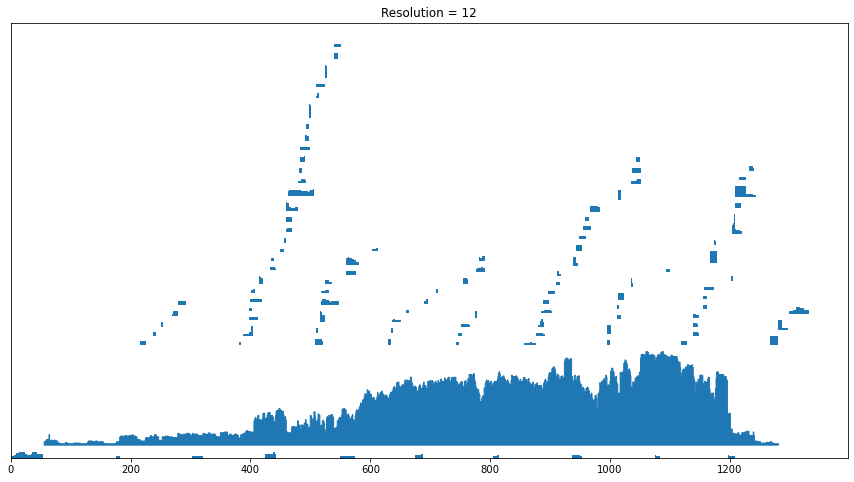

In [30]:
' Colored barcode '

# Compute colored barcode
Resolution = 12
start_time = ChronometerStart('GetZigZag... ')
BARCODE, BARCODE_elements = GetZigZag(Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, TypeNodes=Nodes, verbose=True, sanitycheck=False, plot=False)
ChronometerStop(start_time, 's')

# Plot colored barcode
SmallBarsHeight, SmallBarsLength = 3, 3
GRID, FILL = InitializePlotZigZagBarcode(BARCODE, BARCODE_elements, Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, Vertices=Vertices, small_bars_height=SmallBarsHeight, small_bars_length=SmallBarsLength)
PlotZigZagBarcode(FILL, TypeResolution=ResolutionType, show_grid=False)
plt.title('Resolution = '+repr(Resolution)); plt.yticks([]); plt.xlim(left=0); plt.ylim(bottom=0);

# VII - Conference

Loading dataset Conference...
Maximal time value = 10617
Number of timestamps: 5246
Number of vertices: 113
Number of edges events: 20818
Number of edges: 2196
Number of labels: 1
Execution time: 5 s.


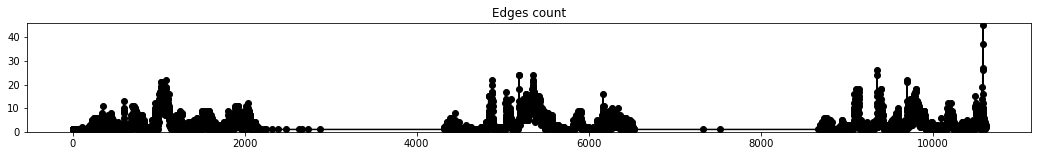

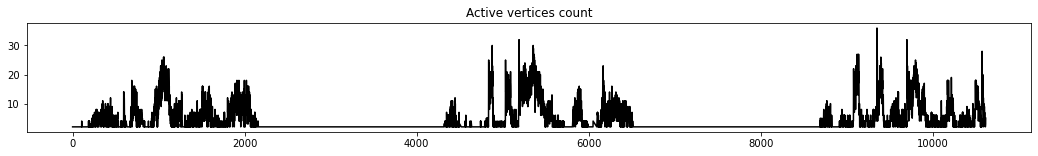

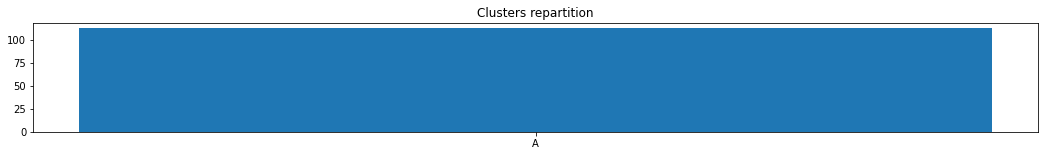

In [31]:
' Open dataset '

# Reinitialize global variables
SaveBarcodes, SaveBarcodesDionysus = dict(), dict()

# Select a temporal graph in the list
Dataset = Files[6]

# Load dataset
start_time = ChronometerStart('Loading dataset '+Dataset+'...\n')
Times, Vertices, Edges_by_times, Edges_unique, Labels_nodes, Labels_color = LoadDataset(Dataset)
ChronometerStop(start_time, 's')

# Plot dataset 
PlotDataset()
plt.show()

Barcode 374/374, resolution = 748... Duration 0:00:24/0:00:00. Execution time: 26 s.
The suggested resolutions are: [12, 22, 30, 42, 224]


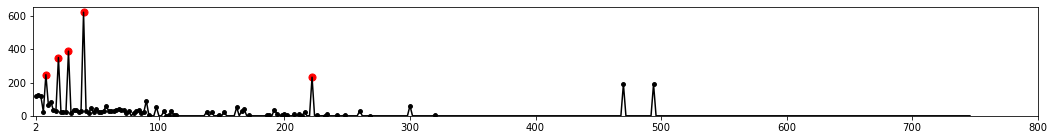

In [32]:
' Resolution suggestion '

# Parameters
Resolution = 100
ResolutionType = ['partition', 'sliding'][1]
MaximalTime = 3000
Nodes = ['active', 'all'][0]

# Compute suggestion curve 
N_peaks = 5
SuggestionTmin, SuggestionTmax = 2, 750 
ResolutionsToTest = list(range(SuggestionTmin,SuggestionTmax,2))
SuggestionCurve = ComputeSuggestionCurve(ResolutionsToTest=ResolutionsToTest, Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, TypeNodes=Nodes, verbose=True, plot=False)

# Select most prominent peaks
TopPeaks = GetTopPeaks(SuggestionCurve,N_peaks)
TopResolutions = [ResolutionsToTest[i]+2 for i in TopPeaks]
print('The suggested resolutions are:', TopResolutions)

# Plot
plt.figure(figsize=(18,2))
plt.plot(ResolutionsToTest[:-1],SuggestionCurve, color='black')
positivevalues = [i for i in range(len(SuggestionCurve)) if SuggestionCurve[i]>0]
plt.scatter([ResolutionsToTest[i] for i in positivevalues],[SuggestionCurve[i] for i in positivevalues], color='black', s=15)
plt.scatter([ResolutionsToTest[i] for i in TopPeaks],[SuggestionCurve[i] for i in TopPeaks], color='red', s=50)
plt.xlim(0,SuggestionTmax-2); plt.ylim(bottom=0); plt.xticks([2]+list(plt.xticks()[0][1:]));

# # Plot smaller
# plt.figure(figsize=(10,2))
# plt.plot(ResolutionsToTest[:-1],SuggestionCurve, color='black')
# positivevalues = [i for i in range(len(SuggestionCurve)) if SuggestionCurve[i]>0]
# plt.scatter([ResolutionsToTest[i] for i in positivevalues],[SuggestionCurve[i] for i in positivevalues], color='black', s=15)
# plt.scatter([ResolutionsToTest[i] for i in TopPeaks],[SuggestionCurve[i] for i in TopPeaks], color='red', s=50)
# plt.xlim(0,SuggestionTmax-2); plt.ylim(bottom=0); plt.xticks([2]+list(plt.xticks()[0][1:]));

Get barcode... Event 4764/4764... Duration 0:00:01/0:00:00. 
There are 342 nonzero bars (and 1605 bars)
Execution time: 1 s.


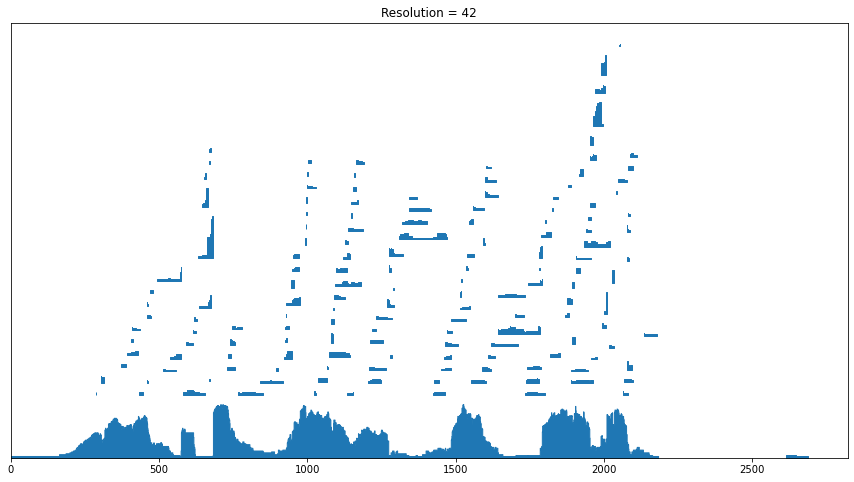

In [33]:
' Colored barcode '

# Compute colored barcode
Resolution = 42
start_time = ChronometerStart('GetZigZag... ')
BARCODE, BARCODE_elements = GetZigZag(Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, TypeNodes=Nodes, verbose=True, sanitycheck=False, plot=False)
ChronometerStop(start_time, 's')

# Plot colored barcode
SmallBarsHeight, SmallBarsLength = 3, 3
GRID, FILL = InitializePlotZigZagBarcode(BARCODE, BARCODE_elements, Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, Vertices=Vertices, small_bars_height=SmallBarsHeight, small_bars_length=SmallBarsLength)
PlotZigZagBarcode(FILL, TypeResolution=ResolutionType, show_grid=False)
plt.title('Resolution = '+repr(Resolution)); plt.yticks([]); plt.xlim(left=0); plt.ylim(bottom=0);

# VIII - Sexual

Loading dataset Sexual...
Maximal time value = 999
Number of timestamps: 1000
Number of vertices: 12157
Number of edges events: 34060
Number of edges: 26383
Number of labels: 2
Execution time: 10 s.


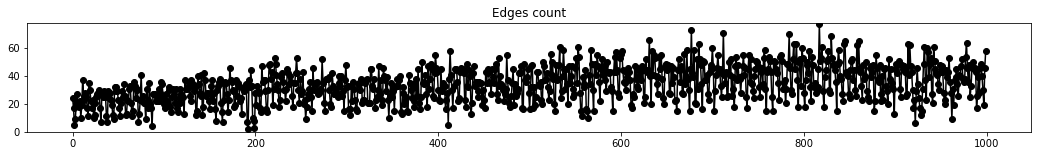

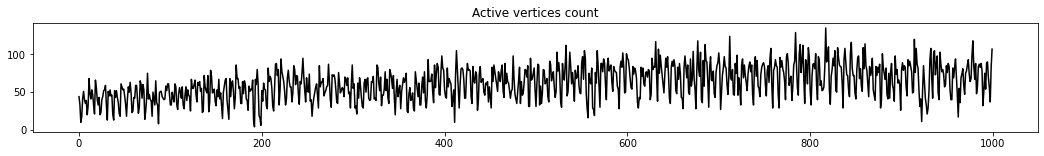

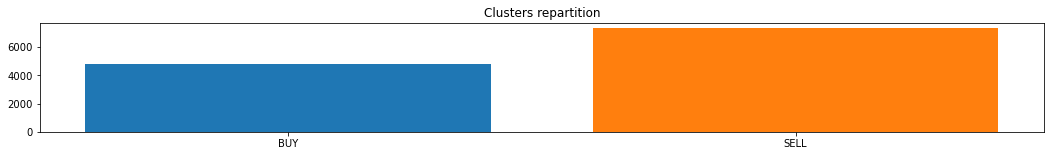

In [34]:
' Open dataset '

# Reinitialize global variables
SaveBarcodes, SaveBarcodesDionysus = dict(), dict()

# Select a temporal graph in the list
Dataset = Files[7]

# Load dataset
start_time = ChronometerStart('Loading dataset '+Dataset+'...\n')
Times, Vertices, Edges_by_times, Edges_unique, Labels_nodes, Labels_color = LoadDataset(Dataset)
ChronometerStop(start_time, 's')

# Plot dataset 
PlotDataset()
plt.show()

Barcode 124/124, resolution = 248... Duration 0:05:26/0:00:00. Execution time: 395 s.
The suggested resolutions are: [6, 160, 186, 226, 240]


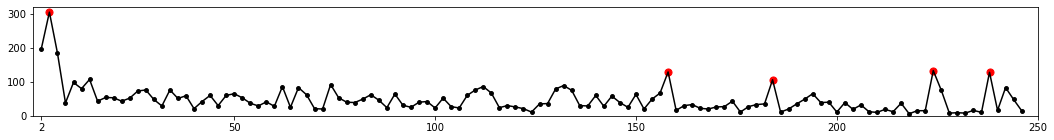

In [35]:
' Resolution suggestion '

# Parameters
Resolution = 100
ResolutionType = ['partition', 'sliding'][1]
MaximalTime = 1000
Nodes = ['active', 'all'][0]

# Compute suggestion curve 
N_peaks = 5
SuggestionTmin, SuggestionTmax = 2, 250 
ResolutionsToTest = list(range(SuggestionTmin,SuggestionTmax,2))
SuggestionCurve = ComputeSuggestionCurve(ResolutionsToTest=ResolutionsToTest, Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, TypeNodes=Nodes, verbose=True, plot=False)

# Select most prominent peaks
TopPeaks = GetTopPeaks(SuggestionCurve,N_peaks)
TopResolutions = [ResolutionsToTest[i]+2 for i in TopPeaks]
print('The suggested resolutions are:', TopResolutions)

# Plot
plt.figure(figsize=(18,2))
plt.plot(ResolutionsToTest[:-1],SuggestionCurve, color='black')
positivevalues = [i for i in range(len(SuggestionCurve)) if SuggestionCurve[i]>0]
plt.scatter([ResolutionsToTest[i] for i in positivevalues],[SuggestionCurve[i] for i in positivevalues], color='black', s=15)
plt.scatter([ResolutionsToTest[i] for i in TopPeaks],[SuggestionCurve[i] for i in TopPeaks], color='red', s=50)
plt.xlim(0,SuggestionTmax-2); plt.ylim(bottom=0); plt.xticks([2]+list(plt.xticks()[0][1:]));

# # Plot smaller
# plt.figure(figsize=(10,2))
# plt.plot(ResolutionsToTest[:-1],SuggestionCurve, color='black')
# positivevalues = [i for i in range(len(SuggestionCurve)) if SuggestionCurve[i]>0]
# plt.scatter([ResolutionsToTest[i] for i in positivevalues],[SuggestionCurve[i] for i in positivevalues], color='black', s=15)
# plt.scatter([ResolutionsToTest[i] for i in TopPeaks],[SuggestionCurve[i] for i in TopPeaks], color='red', s=50)
# plt.xlim(0,SuggestionTmax-2); plt.ylim(bottom=0); plt.xticks([2]+list(plt.xticks()[0][1:]));

Get barcode... Event 157472/157472... Duration 0:08:01/0:00:00. 
There are 16340 nonzero bars (and 78647 bars)
Execution time: 504 s.


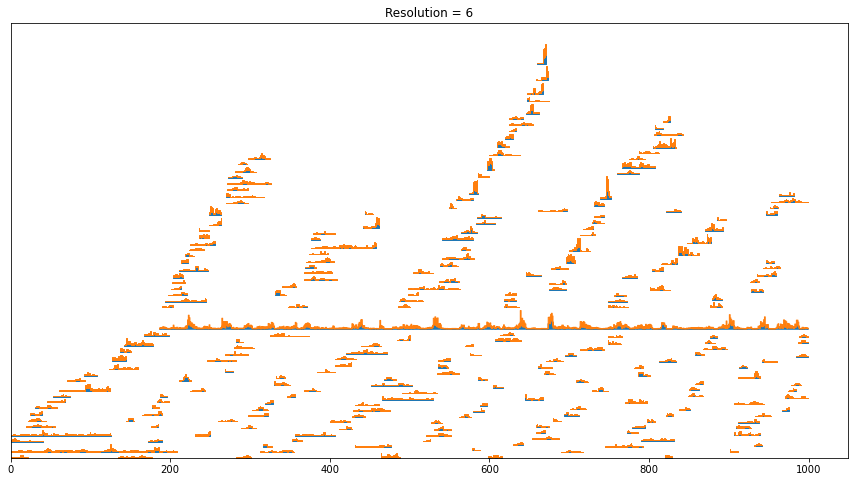

In [36]:
' Colored barcode '

# Compute colored barcode
Resolution = 6
start_time = ChronometerStart('GetZigZag... ')
BARCODE, BARCODE_elements = GetZigZag(Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, TypeNodes=Nodes, verbose=True, sanitycheck=False, plot=False)
ChronometerStop(start_time, 's')

# Plot colored barcode
SmallBarsHeight, SmallBarsLength = 10, 10
GRID, FILL = InitializePlotZigZagBarcode(BARCODE, BARCODE_elements, Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, Vertices=Vertices, small_bars_height=SmallBarsHeight, small_bars_length=SmallBarsLength)
PlotZigZagBarcode(FILL, TypeResolution=ResolutionType, show_grid=False)
plt.title('Resolution = '+repr(Resolution)); plt.yticks([]); plt.xlim(left=0); plt.ylim(bottom=0);

# IX - Twitter

Loading dataset Twitter...
Maximal time value = 223
Number of timestamps: 224
Number of vertices: 50514
Number of edges events: 107803
Number of edges: 80924
Number of labels: 1
Execution time: 29 s.


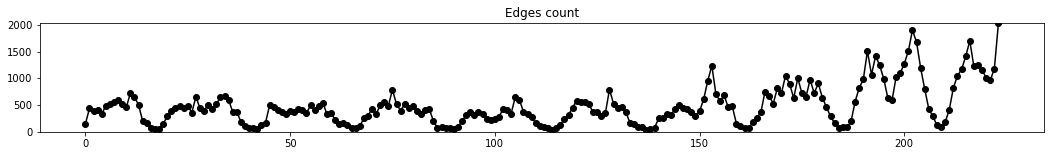

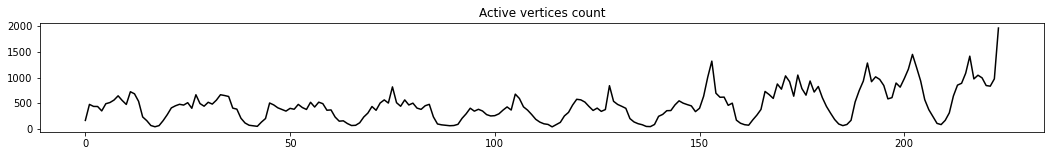

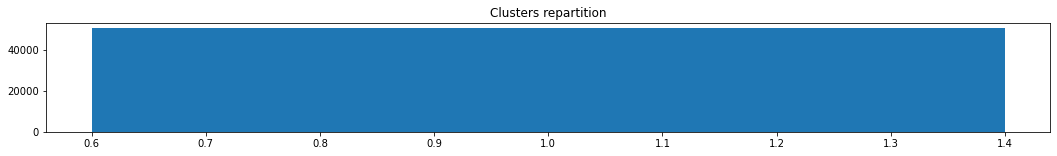

In [37]:
' Open dataset '

# Reinitialize global variables
SaveBarcodes, SaveBarcodesDionysus = dict(), dict()

# Select a temporal graph in the list
Dataset = Files[8]

# Load dataset
start_time = ChronometerStart('Loading dataset '+Dataset+'...\n')
Times, Vertices, Edges_by_times, Edges_unique, Labels_nodes, Labels_color = LoadDataset(Dataset)
ChronometerStop(start_time, 's')

# Plot dataset 
PlotDataset()
plt.show()

Barcode 38/38, resolution = 76... Duration 0:19:16/0:00:00. Execution time: 1223 s.
The suggested resolutions are: [14, 22, 42, 52, 70]


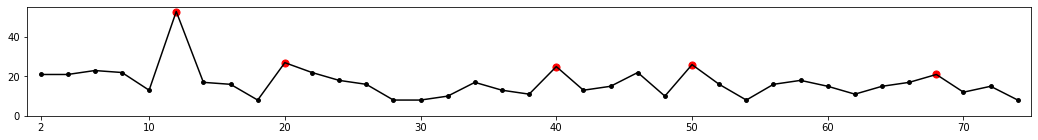

In [38]:
' Resolution suggestion '

# Parameters
Resolution = 100
ResolutionType = ['partition', 'sliding'][1]
MaximalTime = 200
Nodes = ['active', 'all'][0]

# Compute suggestion curve 
N_peaks = 5
SuggestionTmin, SuggestionTmax = 2, 75+2 
ResolutionsToTest = list(range(SuggestionTmin,SuggestionTmax,2))
SuggestionCurve = ComputeSuggestionCurve(ResolutionsToTest=ResolutionsToTest, Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, TypeNodes=Nodes, verbose=True, plot=False)

# Select most prominent peaks
TopPeaks = GetTopPeaks(SuggestionCurve,N_peaks)
TopResolutions = [ResolutionsToTest[i]+2 for i in TopPeaks]
print('The suggested resolutions are:', TopResolutions)

# Plot
plt.figure(figsize=(18,2))
plt.plot(ResolutionsToTest[:-1],SuggestionCurve, color='black')
positivevalues = [i for i in range(len(SuggestionCurve)) if SuggestionCurve[i]>0]
plt.scatter([ResolutionsToTest[i] for i in positivevalues],[SuggestionCurve[i] for i in positivevalues], color='black', s=15)
plt.scatter([ResolutionsToTest[i] for i in TopPeaks],[SuggestionCurve[i] for i in TopPeaks], color='red', s=50)
plt.xlim(1,SuggestionTmax-2); plt.ylim(bottom=0); plt.xticks([2]+list(plt.xticks()[0][1:-1]));

# # Plot smaller
# plt.figure(figsize=(10,2))
# plt.plot(ResolutionsToTest[:-1],SuggestionCurve, color='black')
# positivevalues = [i for i in range(len(SuggestionCurve)) if SuggestionCurve[i]>0]
# plt.scatter([ResolutionsToTest[i] for i in positivevalues],[SuggestionCurve[i] for i in positivevalues], color='black', s=15)
# plt.scatter([ResolutionsToTest[i] for i in TopPeaks],[SuggestionCurve[i] for i in TopPeaks], color='red', s=50)
# plt.xlim(1,SuggestionTmax-2); plt.ylim(bottom=0); plt.xticks([2]+list(plt.xticks()[0][1:-1]));

In [39]:
# ' Colored barcode '

# # Compute colored barcode
# Resolution = 14
# start_time = ChronometerStart('GetZigZag... ')
# BARCODE, BARCODE_elements = GetZigZag(Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, TypeNodes=Nodes, verbose=True, sanitycheck=False, plot=False)
# ChronometerStop(start_time, 's')

# # Plot colored barcode
# SmallBarsHeight, SmallBarsLength = 20, 20
# GRID, FILL = InitializePlotZigZagBarcode(BARCODE, BARCODE_elements, Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, Vertices=Vertices, small_bars_height=SmallBarsHeight, small_bars_length=SmallBarsLength)
# PlotZigZagBarcode(FILL, TypeResolution=ResolutionType, show_grid=False)
# plt.title('Resolution = '+repr(Resolution)); plt.yticks([]); plt.xlim(left=0); plt.ylim(bottom=0);

# X - Malawi
https://epjdatascience.springeropen.com/articles/10.1140/epjds/s13688-021-00302-w

Loading dataset Malawi...
Maximal time value = 1155800
Number of timestamps: 43438
Number of vertices: 86
Number of edges events: 102293
Number of edges: 347
Number of labels: 1
Execution time: 28 s.


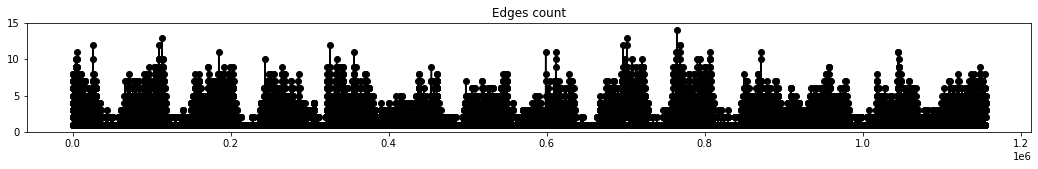

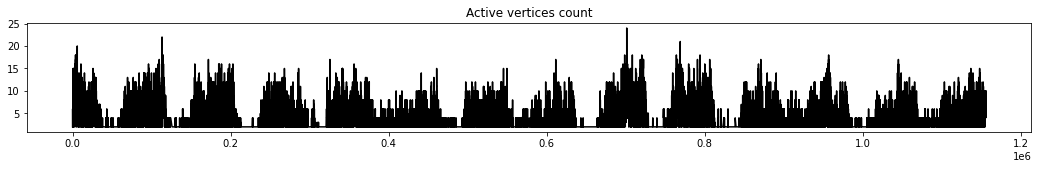

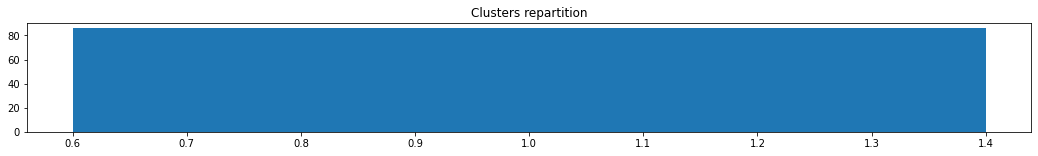

In [40]:
' Open dataset '

# Reinitialize global variables
SaveBarcodes, SaveBarcodesDionysus = dict(), dict()

# Select a temporal graph in the list
Dataset = Files[9]

# Load dataset
start_time = ChronometerStart('Loading dataset '+Dataset+'...\n')
Times, Vertices, Edges_by_times, Edges_unique, Labels_nodes, Labels_color = LoadDataset(Dataset)
ChronometerStop(start_time, 's')

# Plot dataset 
PlotDataset()
plt.show()

Barcode 100/100, resolution = 9902... Duration 0:00:39/0:00:00. Execution time: 67 s.
The suggested resolutions are: [4004, 5904, 7004, 8104, 8404]


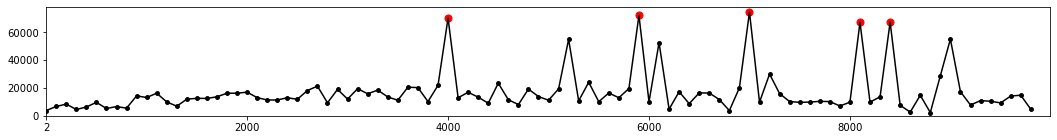

In [41]:
' Resolution suggestion '

# Parameters
Resolution = 100
ResolutionType = ['partition', 'sliding'][1]
MaximalTime = 1000000
Nodes = ['active', 'all'][0]

# Compute suggestion curve 
N_peaks = 5
SuggestionTmin, SuggestionTmax = 2, 10000 
ResolutionsToTest = list(range(SuggestionTmin,SuggestionTmax,100))
SuggestionCurve = ComputeSuggestionCurve(ResolutionsToTest=ResolutionsToTest, Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, TypeNodes=Nodes, verbose=True, plot=False)

# Select most prominent peaks
TopPeaks = GetTopPeaks(SuggestionCurve,N_peaks)
TopResolutions = [ResolutionsToTest[i]+2 for i in TopPeaks]
print('The suggested resolutions are:', TopResolutions)

# Plot
plt.figure(figsize=(18,2))
plt.plot(ResolutionsToTest[:-1],SuggestionCurve, color='black')
positivevalues = [i for i in range(len(SuggestionCurve)) if SuggestionCurve[i]>0]
plt.scatter([ResolutionsToTest[i] for i in positivevalues],[SuggestionCurve[i] for i in positivevalues], color='black', s=15)
plt.scatter([ResolutionsToTest[i] for i in TopPeaks],[SuggestionCurve[i] for i in TopPeaks], color='red', s=50)
plt.xlim(1,SuggestionTmax-2); plt.ylim(bottom=0); plt.xticks([2]+list(plt.xticks()[0][1:-1]));

# # Plot smaller
# plt.figure(figsize=(10,2))
# plt.plot(ResolutionsToTest[:-1],SuggestionCurve, color='black')
# positivevalues = [i for i in range(len(SuggestionCurve)) if SuggestionCurve[i]>0]
# plt.scatter([ResolutionsToTest[i] for i in positivevalues],[SuggestionCurve[i] for i in positivevalues], color='black', s=15)
# plt.scatter([ResolutionsToTest[i] for i in TopPeaks],[SuggestionCurve[i] for i in TopPeaks], color='red', s=50)
# plt.xlim(1,SuggestionTmax-2); plt.ylim(bottom=0); plt.xticks([2]+list(plt.xticks()[0][1:-1]));

Get barcode... Event 11377/11377... Duration 0:00:03/0:00:00. 
There are 1130 nonzero bars (and 4856 bars)
Execution time: 3 s.


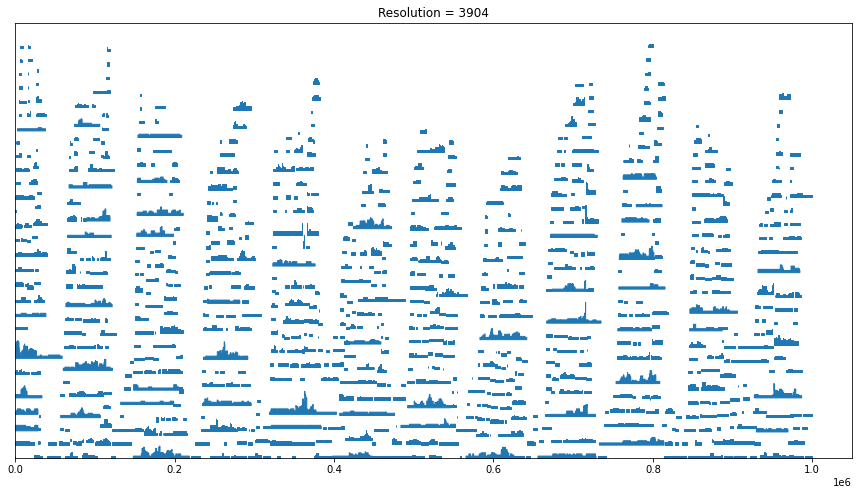

In [42]:
' Colored barcode '

# Compute colored barcode
Resolution = 4004-100
start_time = ChronometerStart('GetZigZag... ')
BARCODE, BARCODE_elements = GetZigZag(Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, TypeNodes=Nodes, verbose=True, sanitycheck=False, plot=False)
ChronometerStop(start_time, 's')

# Plot colored barcode
SmallBarsHeight, SmallBarsLength = 0,0
GRID, FILL = InitializePlotZigZagBarcode(BARCODE, BARCODE_elements, Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, Vertices=Vertices, small_bars_height=SmallBarsHeight, small_bars_length=SmallBarsLength)
PlotZigZagBarcode(FILL, TypeResolution=ResolutionType, show_grid=False)
plt.title('Resolution = '+repr(Resolution)); plt.yticks([]); plt.xlim(left=0); plt.ylim(bottom=0);

# XI - Baboons
http://www.sociopatterns.org/datasets/baboons-interactions/

Loading dataset Baboons...
Maximal time value = 2392040
Number of timestamps: 40846
Number of vertices: 13
Number of edges events: 63095
Number of edges: 78
Number of labels: 13
Execution time: 16 s.


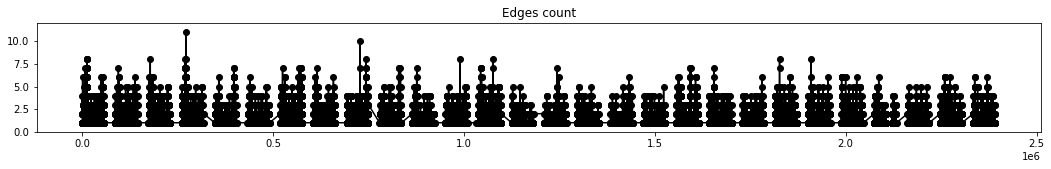

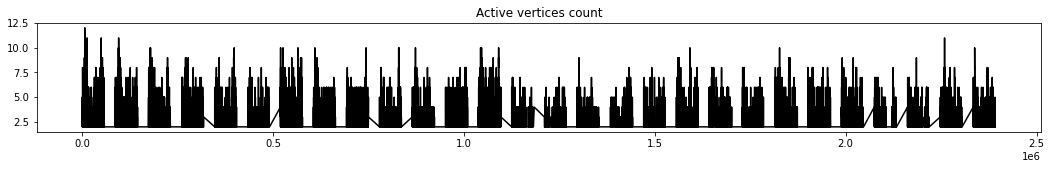

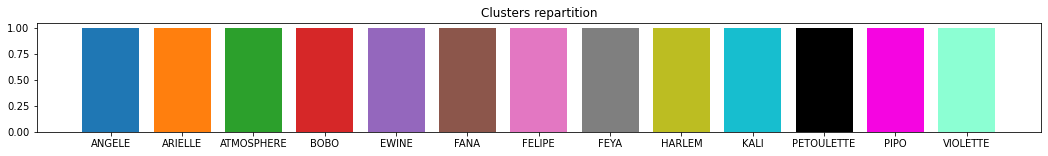

In [43]:
' Open dataset '

# Reinitialize global variables
SaveBarcodes, SaveBarcodesDionysus = dict(), dict()

# Select a temporal graph in the list
Dataset = Files[10]

# Load dataset
start_time = ChronometerStart('Loading dataset '+Dataset+'...\n')
Times, Vertices, Edges_by_times, Edges_unique, Labels_nodes, Labels_color = LoadDataset(Dataset)
ChronometerStop(start_time, 's')

# Plot dataset 
PlotDataset()
plt.show()

Barcode 249/249, resolution = 498... Duration 0:00:03/0:00:00. Execution time: 3 s.
The suggested resolutions are: [20, 140, 240, 440, 480]


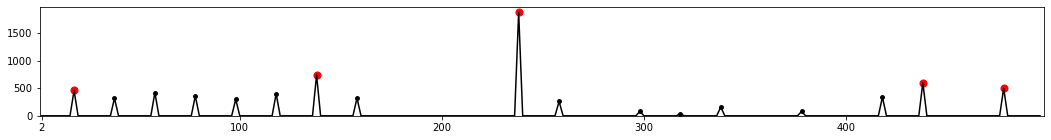

In [44]:
' Resolution suggestion '

# Parameters
Resolution = 100
ResolutionType = ['partition', 'sliding'][1]
MaximalTime = 7500
Nodes = ['active', 'all'][0]

# Compute suggestion curve 
N_peaks = 5
SuggestionTmin, SuggestionTmax = 2, 500
ResolutionsToTest = list(range(SuggestionTmin,SuggestionTmax,2))
SuggestionCurve = ComputeSuggestionCurve(ResolutionsToTest=ResolutionsToTest, Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, TypeNodes=Nodes, verbose=True, plot=False)

# Select most prominent peaks
TopPeaks = GetTopPeaks(SuggestionCurve,N_peaks)
TopResolutions = [ResolutionsToTest[i]+2 for i in TopPeaks]
print('The suggested resolutions are:', TopResolutions)

# Plot
plt.figure(figsize=(18,2))
plt.plot(ResolutionsToTest[:-1],SuggestionCurve, color='black')
positivevalues = [i for i in range(len(SuggestionCurve)) if SuggestionCurve[i]>0]
plt.scatter([ResolutionsToTest[i] for i in positivevalues],[SuggestionCurve[i] for i in positivevalues], color='black', s=15)
plt.scatter([ResolutionsToTest[i] for i in TopPeaks],[SuggestionCurve[i] for i in TopPeaks], color='red', s=50)
plt.xlim(1,SuggestionTmax-2); plt.ylim(bottom=0); plt.xticks([2]+list(plt.xticks()[0][1:-1]));

# # Plot smaller
# plt.figure(figsize=(10,2))
# plt.plot(ResolutionsToTest[:-1],SuggestionCurve, color='black')
# positivevalues = [i for i in range(len(SuggestionCurve)) if SuggestionCurve[i]>0]
# plt.scatter([ResolutionsToTest[i] for i in positivevalues],[SuggestionCurve[i] for i in positivevalues], color='black', s=15)
# plt.scatter([ResolutionsToTest[i] for i in TopPeaks],[SuggestionCurve[i] for i in TopPeaks], color='red', s=50)
# plt.xlim(1,SuggestionTmax-2); plt.ylim(bottom=0); plt.xticks([2]+list(plt.xticks()[0][1:-1]));

Get barcode... Event 300/300... Duration 0:00:00/0:00:00. 
There are 34 nonzero bars (and 129 bars)
Execution time: 0 s.


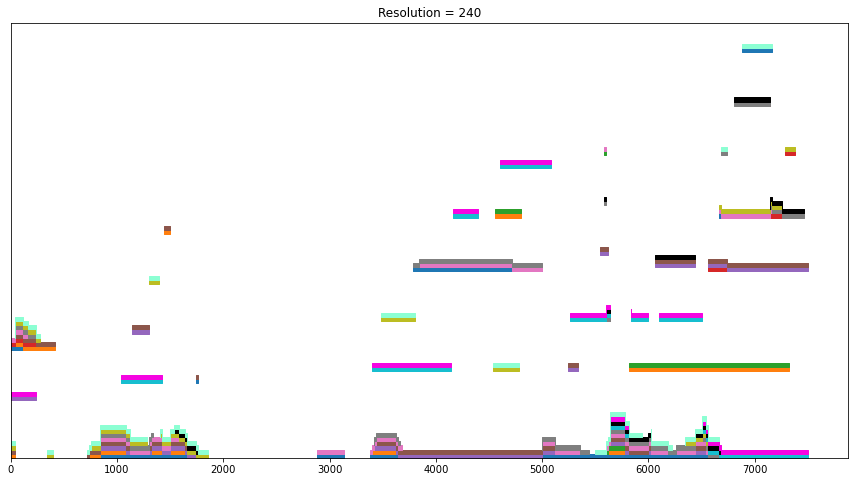

In [45]:
' Colored barcode '

# Compute colored barcode
Resolution = 240
start_time = ChronometerStart('GetZigZag... ')
BARCODE, BARCODE_elements = GetZigZag(Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, TypeNodes=Nodes, verbose=True, sanitycheck=False, plot=False)
ChronometerStop(start_time, 's')

# Plot colored barcode
SmallBarsHeight, SmallBarsLength = 0,2
GRID, FILL = InitializePlotZigZagBarcode(BARCODE, BARCODE_elements, Tmax=MaximalTime, resolution=Resolution, TypeResolution=ResolutionType, Vertices=Vertices, small_bars_height=SmallBarsHeight, small_bars_length=SmallBarsLength)
PlotZigZagBarcode(FILL, TypeResolution=ResolutionType, show_grid=False)
plt.title('Resolution = '+repr(Resolution)); plt.yticks([]); plt.xlim(left=0); plt.ylim(bottom=0);